# Cargar librerias a utilizar

In [1]:
# --- Librerías estándar y científicas ---
import numpy as np  # Manipulación de arreglos numéricos de N dimensiones
import matplotlib.pyplot as plt  # Creación de gráficos y visualizaciones
import matplotlib.colors as colors  # Manejo avanzado de mapeos de colores en gráficos
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Control preciso del layout de los ejes en figuras matplotlib
from scipy.optimize import curve_fit  # Ajuste de curvas a funciones definidas
from scipy.spatial import cKDTree
import pandas as pd
import seaborn as sns

# --- Astropy: manejo de datos astronómicos ---
from astropy import units as u  # Manejo de unidades físicas
from astropy.coordinates import SkyCoord, match_coordinates_sky  # Manejo de coordenadas celestes y emparejamiento en el cielo
from astropy.io import fits  # Lectura y escritura de archivos FITS
from astropy.nddata import Cutout2D  # Extracción de recortes 2D de imágenes
from astropy.stats import sigma_clipped_stats  # Estadísticas robustas con eliminación sigma-clipping
from astropy.wcs import WCS  # Manejo de información de coordenadas WCS (World Coordinate System)
from astropy.table import QTable

# --- Photutils: detección y fotometría de fuentes ---
from photutils.detection import DAOStarFinder  # Detección de estrellas usando el algoritmo DAO
from photutils.aperture import CircularAperture, aperture_photometry  # Fotometría mediante aperturas circulares
from photutils.detection import find_peaks

# --- Astroquery: acceso a catálogos astronómicos ---
from astroquery.gaia import Gaia  # Consulta del catálogo Gaia usando ADQL


# Star Finder to PSF

In [2]:
# --- Configuración inicial ---
# Directorios
DIR = ''
OUTPUT_DIR = DIR + 'output/'

# Nombre del archivo fuente
filename = 'PSJ1606_muse_simple_X_zapped.fits'

# --- Lectura del cubo de datos FITS ---
with fits.open(DIR + filename) as hdul:
    cube = hdul[1].data           # Cubo de datos científicos
    vcube = hdul[2].data          # Varianza (para calcular errores)
    header = hdul[1].header       # Encabezado con información WCS

# WCS 2D para coordenadas espaciales
wcs_2d = WCS(header, naxis=2)

# Imagen de luz blanca (suma a lo largo del eje espectral)
white_img = np.nansum(cube, axis=0)
white_img_err = np.sqrt(np.nansum(vcube, axis=0))

# Vector de longitud de onda observado (en Å)
wave_obs = (np.arange(header['NAXIS3']) - (header['CRPIX3'] - 1)) * header['CD3_3'] + header['CRVAL3']

# Espectro total sumando sobre las dos dimensiones espaciales
#spectrum = np.nansum(cube, axis=(1, 2))

# --- Cálculo de límites en coordenadas celestes ---
ny, nx = cube.shape[1:]
corners_x = [0, nx]
corners_y = [0, ny]

# Transformar píxeles de las esquinas a coordenadas RA/Dec
ra_dec = wcs_2d.pixel_to_world([corners_x[0], corners_x[1], corners_x[0], corners_x[1]],
                               [corners_y[0], corners_y[0], corners_y[1], corners_y[1]])

# Límites de la región en grados
ra_min, ra_max = ra_dec.ra.deg.min(), ra_dec.ra.deg.max()
dec_min, dec_max = ra_dec.dec.deg.min(), ra_dec.dec.deg.max()

# --- Consulta ADQL a Gaia ---
# Se usa un límite de magnitud (G < 19) para restringir a estrellas relativamente brillantes
# astrometric_params_solved > 3: buena solución astrométrica
# classprob_dsc_combmod_star > 0.5: probabilidad de ser estrella

query = f"""
SELECT TOP 10
    source_id, ra, dec, phot_g_mean_mag
FROM gaiadr3.gaia_source
WHERE ra BETWEEN {ra_min} AND {ra_max}
  AND dec BETWEEN {dec_min} AND {dec_max}
  AND phot_g_mean_mag < 22
  AND astrometric_params_solved > 3
  AND classprob_dsc_combmod_star > 0.5
ORDER BY phot_g_mean_mag ASC
"""

job = Gaia.launch_job(query)
gaia_results = job.get_results()
print(gaia_results, "\n")

     source_id              ra                 dec         phot_g_mean_mag
                           deg                 deg               mag      
------------------- ------------------ ------------------- ---------------
6242307018500802048 241.51482538958737 -23.556558458360637       15.671239
6242307048556613376 241.49989742785178   -23.5628218960989       17.557453
6242307082916379008 241.50788684016024  -23.55287888154344       17.780014
6242307052852617856  241.4907407490663 -23.559823599740504       18.049698
6242307048557549056 241.49276723423299 -23.567343122887138       18.302149
6242307014196859904 241.51405830984802  -23.56828658714226        18.61709
6242307014196860032 241.51562384550382   -23.5687570005305       18.916084
6242307048556628096 241.49036667441862  -23.55697362007846       18.920118
6242307396457927808 241.51372455488635  -23.55069310126085       19.144053
6242307289074827776 241.49273418403286 -23.545222009136292       19.292034 



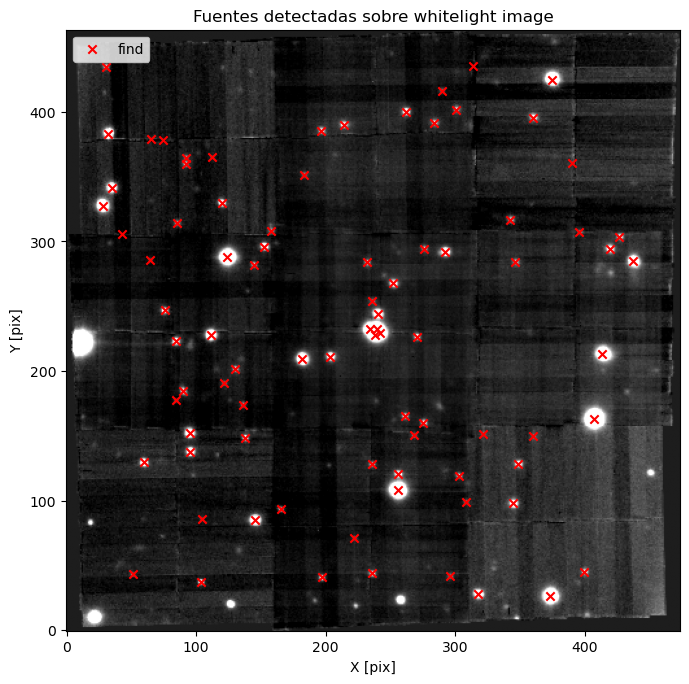

In [3]:
# --- Detección de fuentes con DAOStarFinder ---
# Se usa un umbral de 3 sigma sobre la mediana

mean, median, std = sigma_clipped_stats(white_img, sigma=3.0)
daofind = DAOStarFinder(fwhm=3.0, threshold=3.0 * std)
sources = daofind(white_img - median)

# Coordenadas (x, y) de las fuentes detectadas
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

# --- Filtro para excluir fuentes cerca del borde ---
# Elimina detecciones a menos de X px del borde
MARGIN = 25
inside_mask = (
    (positions[:, 0] > MARGIN) & (positions[:, 0] < nx - MARGIN) &
    (positions[:, 1] > MARGIN) & (positions[:, 1] < ny - MARGIN)
)
positions = positions[inside_mask]

# --- Visualización de la imagen y fuentes detectadas ---
plt.figure(figsize=(7, 7))
plt.imshow(white_img, origin='lower', cmap='gray', vmin=np.percentile(white_img, 5), vmax=np.percentile(white_img, 99))
plt.scatter(positions[:, 0], positions[:, 1], marker='x', color='red', label='find')
plt.title('Fuentes detectadas sobre whitelight image')
plt.xlabel('X [pix]')
plt.ylabel('Y [pix]')
plt.legend(loc="upper left")
plt.grid(False)
plt.tight_layout()
plt.show()


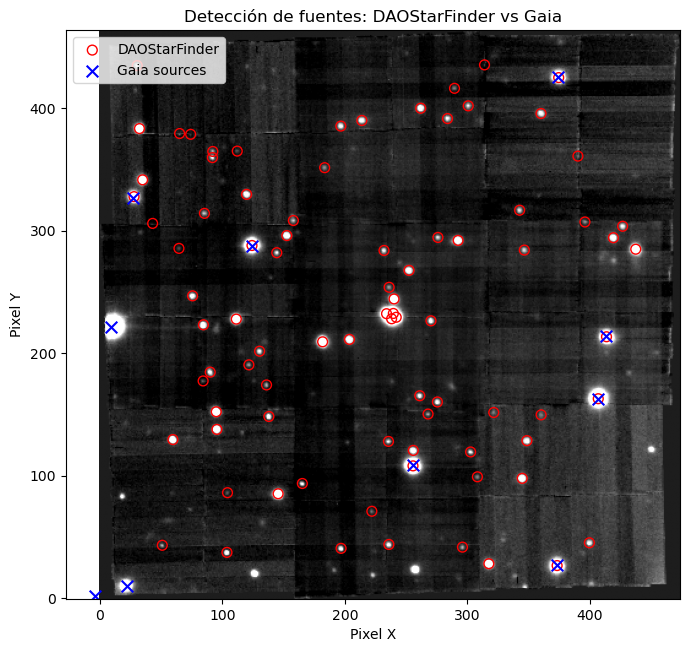

In [4]:
# --- Transformar coordenadas de GAIA (RA, Dec) a píxeles ---

rel_pos_ra, rel_pos_dec = 0.0001*3 ,-0.0005*1.4

gaia_coords_corr = SkyCoord(ra=gaia_results['ra']+rel_pos_ra, dec=gaia_results['dec']+rel_pos_dec, unit='deg')
gaia_pixels = wcs_2d.world_to_pixel(gaia_coords_corr)


# --- Mostrar imagen con detecciones DAOStarFinder y Gaia ---
plt.figure(figsize=(7, 7))
plt.imshow(white_img, origin='lower', cmap='gray', vmin=np.percentile(white_img, 5), vmax=np.percentile(white_img, 99))

# Fuentes detectadas por DAOStarFinder (rojo)
plt.scatter(positions[:, 0], positions[:, 1], s=50, edgecolor='red', facecolor='none', marker='o', label='DAOStarFinder')

# Fuentes Gaia transformadas (azul)
plt.scatter(gaia_pixels[0], gaia_pixels[1], s=70, color='blue', marker='x', label='Gaia sources')

plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.title('Detección de fuentes: DAOStarFinder vs Gaia')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



Number of matches: 7

Number of clean matches: 5

[[373.21030579  26.57237514]
 [406.78734554 162.74561609]
 [413.52051692 213.32342591]
 [124.14649836 287.81265587]
 [374.49381479 424.83183647]]
 ID     img_RA_deg        img_Dec_deg    
--- ------------------ ------------------
  1 241.49306874348522 241.49306874348522
  2 241.49103391434213 241.49103391434213
  3  241.4906259593612  241.4906259593612
  4  241.5081635797751  241.5081635797751
  5 241.49299156223728 241.49299156223728


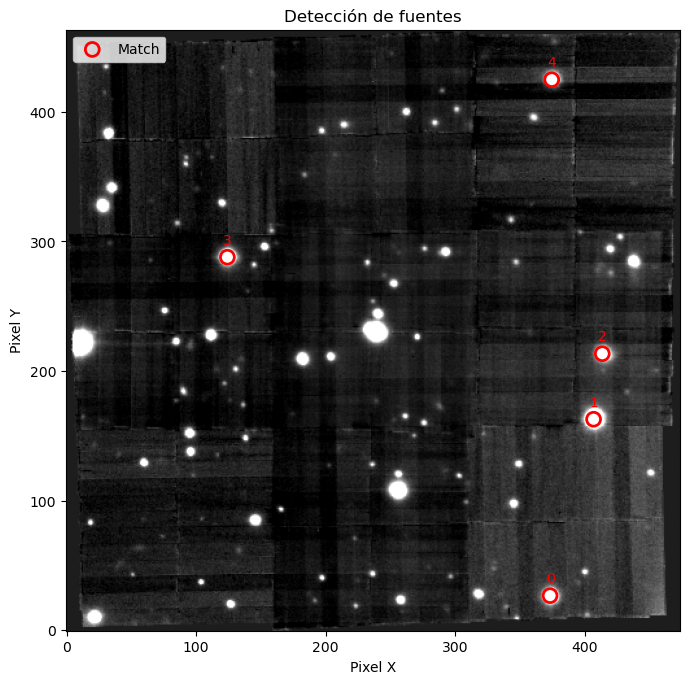

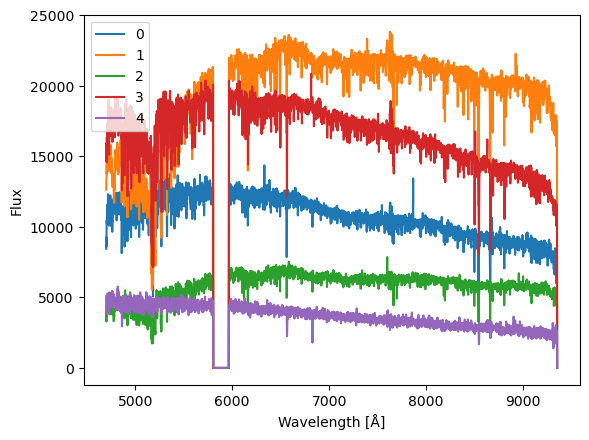

In [5]:


# --- Transformación pixeles a coordenadas celestes (fuentes encontradas) ---
sources_sky_coords = wcs_2d.pixel_to_world(positions[:, 0], positions[:, 1])

# --- Cruce de posiciones con Gaia ---
#gaia_coords = SkyCoord(ra=gaia_results['ra'], dec=gaia_results['dec'], unit='deg')

rel_pos_ra, rel_pos_dec = 0.0001*3 ,-0.0005*1.4

gaia_coords_corr = SkyCoord(ra=gaia_results['ra']+rel_pos_ra, dec=gaia_results['dec']+rel_pos_dec, unit='deg')
idx, d2d, _ = match_coordinates_sky(sources_sky_coords, gaia_coords_corr)

# Selecciona coincidencias dentro de 2 arcsec
MATCH_RADIUS = 2.0 * u.arcsec
matched = d2d <= MATCH_RADIUS

print(f"Number of matches: {np.sum(matched)}\n")

# Obtener posiciones y coordenadas coincidentes
matched_positions = positions[matched]
matched_coords = sources_sky_coords[matched]
#stars_coords = np.column_stack((matched_coords.ra.deg, matched_coords.dec.deg))
#print(matched_coords, "\n")
#print(" ")
#matched_coords_gaia = gaia_coords_corr[idx[matched]]
#print(matched_coords_gaia, "\n")


# Usar TODAS las detecciones (positions) para filtrar objetos cercanos
tree_all = cKDTree(positions)
distances, _ = tree_all.query(matched_positions, k=2)  # para cada matched, obtener vecino más cercano
nearest_neighbor_dist = distances[:, 1]

min_sep_pixels = 20  # umbral en píxeles para considerar que una estrella está contaminada
isolated_mask = nearest_neighbor_dist > min_sep_pixels

matched_positions_nocont = matched_positions[isolated_mask]
matched_coords_nocont = matched_coords[isolated_mask]

print(f"Number of clean matches: {len(matched_coords_nocont)}\n")


print(matched_positions_nocont)

# --- Tabla ordenada con los datos emparejados sin contaminacion -- 
matched_table = QTable()
matched_table['ID'] = np.arange(1, np.sum(isolated_mask)+1)
matched_table['img_RA_deg'] = matched_coords_nocont.ra.deg
matched_table['img_Dec_deg'] = matched_coords_nocont.ra.deg
print(matched_table)



# --- Mostrar imagen con detecciones DAOStarFinder y Gaia ---
plt.figure(figsize=(7, 7))
plt.imshow(white_img, origin='lower', cmap='gray', vmin=np.percentile(white_img, 5), vmax=np.percentile(white_img, 99))

# Fuentes detectadas por DAOStarFinder (rojo)
plt.scatter(matched_positions_nocont[:, 0], matched_positions_nocont[:, 1], s=100,linewidths=2, edgecolor='red', facecolor='none', marker='o', label='Match')
for i, (x, y) in enumerate(matched_positions_nocont):
    plt.text(x, y + 10, str(i), color='red', fontsize=10, ha='center')


plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.title('Detección de fuentes')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



# --- Espectros de las estrellas tomadas ---

pixel_scale = 0.2  # arcsec/pixel
aperture_radius_pix = 1 / pixel_scale

for i, pos in enumerate(matched_positions_nocont):
    y, x = int(pos[1]), int(pos[0])
    yy, xx = np.ogrid[:cube.shape[1], :cube.shape[2]]
    mask = (xx - x)**2 + (yy - y)**2 <= aperture_radius_pix**2
    spectrum_obj = np.nansum(cube[:, mask], axis=1)
    plt.plot(wave_obs, spectrum_obj, label=f'{i}')

plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.legend()
plt.show()



# PSF and object treatmen


## Metodo artesanal de PSF

### Funciones de utilidad

In [6]:
# Some useful functions:
# Get an azimuthal-averaged radial profile by using some radial coordinates
def radial_prof(img, rcoord, width=1.0, model=None, check_zeros=True):    # width cambiado de 2 a 1
    if check_zeros:
        zeros = img == 0
        img[zeros] = np.nan
        
        if model is not None:
            model[zeros] = np.nan

    rcoord_norm = rcoord // width
        
    r_arr, prof_arr, model_arr = [], [], []
    for r in np.unique(rcoord_norm):            
        sel = rcoord_norm == r
        
        img_sel = img[sel]
        if len(img_sel) < 1:  # just in case only one pixel is selected.
            continue
        
        r_arr.append(r)
        prof_arr.append(np.nanmean(img_sel))
        
        if model is not None:
            model_arr.append(np.nanmean(model[sel]))
        
    if model is None:
        model_arr = np.nan    
    
    return np.array(r_arr), np.array(prof_arr), np.array(model_arr)

# Two-dimensional (circular) Moffat profile
def moffat2D(coord, *params): # params: x0, y0, fwhm, beta, amplitude

    x, y = coord
    x0, y0, amplitude, fwhm, beta, = params

    alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
    r2 = (x - x0)**2 + (y - y0)**2
    model = amplitude / (1 + r2/alpha**2)**beta
    
    return model.ravel()

# 2D Sersic model. Could be useful.
def sersic2D(coord, pars):
    x, y = coord
    x0, y0, PA, Q, I0, Re, n = pars 
    
    xr = (x-x0) * np.cos(PA) + (y-y0) * np.sin(PA)
    yr = -(x-x0) * np.sin(PA) + (y-y0) * np.cos(PA)
    R = np.sqrt(xr**2 + (yr/Q)**2)
    
    bn = 2*n-0.333
    z = I0 * np.exp(-bn * (R/Re)**(1/n))
    
    return z.ravel()

# Fit the lensed qso image. It assumes a moffat2D function is called.
def lens_qso_fit(coord, *params):

    z = np.zeros(np.shape(coord[0])).ravel()
    for i in range(0, len(params), 5):
        
        subparams = params[i:i+5]
        z += moffat2D(coord, *subparams)
        
    #z += sersic2D(coord, params[-7:])
    
    return z

# Auxiliar plot function
def do_imshow_plot(img, mod, res, Npars=0, ncols=3, mask=None, title=None):
    # Ploting cutout image and model
    fig, ax = plt.subplots(ncols=ncols, nrows=1, figsize=(3*ncols,3))

    minval = np.nanmin(img) # to re-scale and not consider negative values
    if mask is not None:
        p = np.nanpercentile(img[mask]-minval, [16, 99.5]) # to normalize color scale
    else:
        p = np.nanpercentile(img-minval, [16, 99.5])
    

    # Asegura que vmin > 0 y que vmin < vmax
    #if p[0] <= 0 or p[0] == p[1] or not np.isfinite(p).all():
    #    p[0] = max(1e-3, p[1] * 1e-2)  # o algún valor mínimo arbitrario positivo

    col_norm = colors.LogNorm(vmin=p[0], vmax=p[1])

    
    ax[0].imshow(img-minval, origin='lower', norm=col_norm)
    ax[1].imshow(mod-minval, origin='lower', norm=col_norm)
    
    im = ax[2].imshow(res, origin='lower', vmin=-5, vmax=5, cmap='RdBu_r')
        
    # color bar for residuals
    cax = fig.add_axes([0.69, 0.24, 0.075, 0.025])
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[-5, 0, 5])
    cbar.ax.set_xticklabels([r'-5$\sigma$', '0', r'5$\sigma$'])
    
    # some text
    ax[0].text(0.02, 0.9, 'Star', color='w', transform=ax[0].transAxes)
    ax[1].text(0.02, 0.9, 'Model', color='w', transform=ax[1].transAxes)
    ax[2].text(0.02, 0.9, 'Residuals', color='k', transform=ax[2].transAxes)
    
    if mask is not None:    
        chi2_r = np.nansum(res**2) / (img.size-Npars)      # reduced chi-square value
    else:
        chi2_r = np.nansum(res[mask]**2) / (img[mask].size-Npars)

    ax[1].text(0.6, 0.9, r'$\chi^2_\nu = $'+format(chi2_r,'.5f'), 
                          color='w', 
                          transform=ax[1].transAxes)
    
    if title is not None:
        ax[1].set_title(title)

    for i in range(ncols):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
    plt.show()

    return chi2_r

### Star PSF modeling (White-Image) and normalization

/tmp/ipykernel_2644589/2208832662.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)


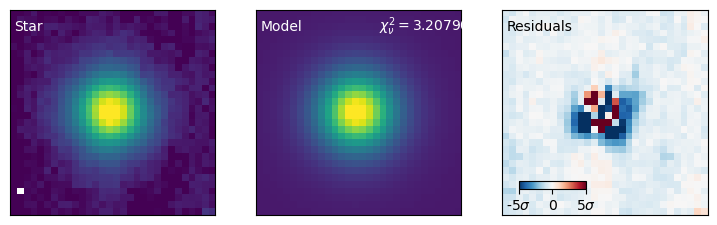

Star 0:
  x0 = 14.208
  y0 = 14.538
  amplitude = 1.124e+00
  FWHM = 3.153
  beta = 2.417
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 2.1815982e+06  1.2849004e+06  5.7665462e+05  2.4194223e+05
  1.0225636e+05  4.6277371e+04  2.3360895e+04  1.3138411e+04
  6.9848262e+03  3.7632603e+03  1.7446888e+03  2.0519183e+02
 -5.3473138e+02 -1.1713383e+03 -1.5434821e+03 -1.8560883e+03
 -1.8143817e+03 -1.5324172e+03 -1.6550959e+03 -1.8815845e+03
 -2.0999707e+02]
 
  fit_prof = [2.2266815e+06 1.2569188e+06 5.8298131e+05 2.5896070e+05 1.1347391e+05
 5.2292613e+04 2.6486363e+04 1.4878215e+04 8.7306826e+03 5.3077485e+03
 3.3860227e+03 2.2484089e+03 1.5308987e+03 1.0648743e+03 7.6318365e+02
 5.7402448e+02 4.2689261e+02 3.2135715e+02 2.4514508e+02 1.9138847e+02
 1.5792302e+02]


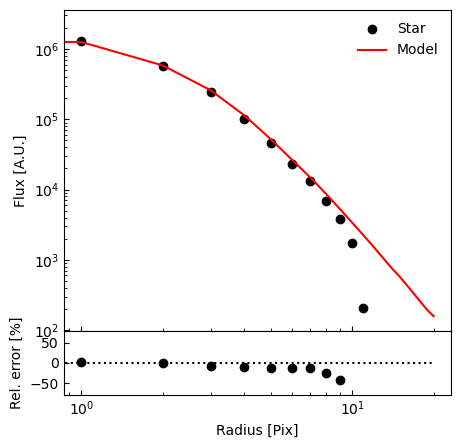

/tmp/ipykernel_2644589/2208832662.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)


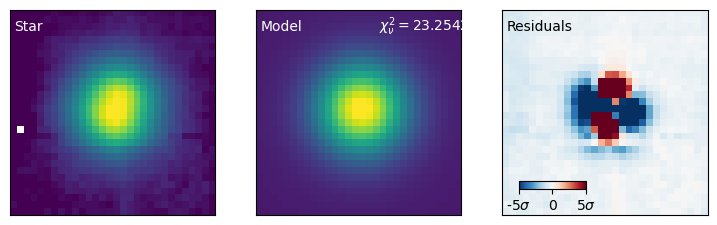

Star 1:
  x0 = 14.884
  y0 = 14.985
  amplitude = 1.016e+00
  FWHM = 4.282
  beta = 2.942
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]
 
  img_prof = [ 2.8773800e+06  2.1991880e+06  1.3504645e+06  7.1548619e+05
  3.2035922e+05  1.5108002e+05  7.1022617e+04  3.7799645e+04
  2.1065705e+04  1.1370221e+04  5.9752051e+03  2.0984885e+03
 -3.2493491e+02 -1.6100859e+03 -3.1968496e+03 -3.2509897e+03
 -3.8987834e+03 -3.3022422e+03 -4.5925190e+03 -5.9565610e+03
 -5.3749795e+03 -5.8278911e+03]
 
  fit_prof = [2.8331220e+06 2.2110950e+06 1.3138250e+06 6.9892562e+05 3.3926931e+05
 1.6453270e+05 8.5286242e+04 4.5861734e+04 2.5651586e+04 1.4823072e+04
 8.9303340e+03 5.6146021e+03 3.6060747e+03 2.3845820e+03 1.6145143e+03
 1.1268220e+03 7.9505341e+02 5.6595959e+02 4.2083688e+02 3.1773532e+02
 2.3302074e+02 1.9520477e+02]


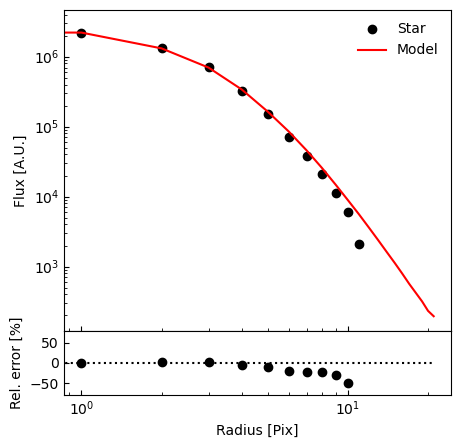

/tmp/ipykernel_2644589/2208832662.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)


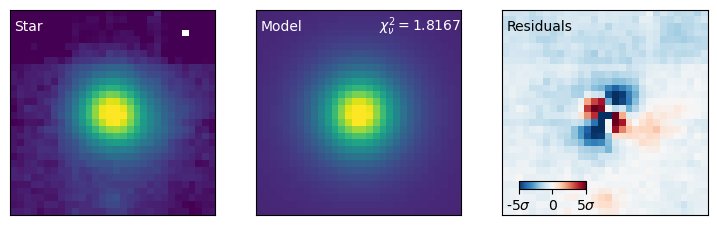

Star 2:
  x0 = 14.539
  y0 = 14.304
  amplitude = 1.136e+00
  FWHM = 3.218
  beta = 1.816
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 1.0926748e+06  6.6260175e+05  3.1715850e+05  1.4509702e+05
  6.9771164e+04  3.6552848e+04  2.1444320e+04  1.2665847e+04
  7.5101318e+03  4.3151660e+03  1.9078125e+03  8.2648071e+02
 -2.4311650e+02 -6.0457782e+02 -1.4131814e+03 -2.5368335e+03
 -3.1004014e+03 -3.9912776e+03 -3.7827959e+03 -4.4646621e+03
 -3.1590044e+03]
 
  fit_prof = [1.1094042e+06 6.4892094e+05 3.2308247e+05 1.5557723e+05 7.9213047e+04
 4.3506109e+04 2.5769229e+04 1.6466031e+04 1.0884299e+04 7.4577402e+03
 5.2716367e+03 3.8286294e+03 2.8678003e+03 2.1871289e+03 1.7045122e+03
 1.3732594e+03 1.0912462e+03 8.7989307e+02 7.2179932e+02 5.9600317e+02
 4.9765836e+02]


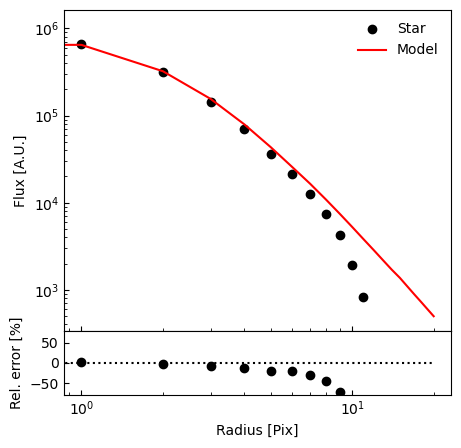

/tmp/ipykernel_2644589/2208832662.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)


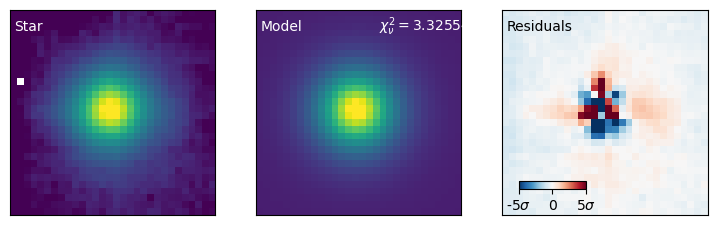

Star 3:
  x0 = 14.139
  y0 = 14.839
  amplitude = 1.051e+00
  FWHM = 2.616
  beta = 2.293
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]
 
  img_prof = [ 4.4780340e+06  2.4991098e+06  8.9926038e+05  3.2624006e+05
  1.3365447e+05  6.3202074e+04  3.3576289e+04  1.9088723e+04
  1.1241626e+04  6.7170762e+03  3.6662603e+03  1.6509391e+03
 -7.0802811e+01 -1.0786775e+03 -2.0188177e+03 -2.3056611e+03
 -2.1426184e+03 -2.8989160e+03 -2.9740217e+03 -3.7858501e+03
 -3.9016692e+03 -2.3387927e+03]
 
  fit_prof = [4.5177640e+06 2.4751740e+06 9.0731150e+05 3.2995816e+05 1.3352231e+05
 6.0781641e+04 3.1080588e+04 1.7172506e+04 1.0105887e+04 6.2329399e+03
 3.9873621e+03 2.6597695e+03 1.8407363e+03 1.3037881e+03 9.4499951e+02
 7.0727264e+02 5.2789838e+02 4.0328488e+02 3.1591754e+02 2.5065475e+02
 2.0419827e+02 1.7604564e+02]


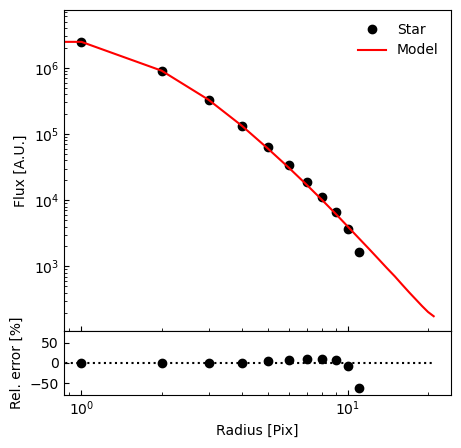

/tmp/ipykernel_2644589/2208832662.py:38: RuntimeWarning: invalid value encountered in sqrt
  alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)


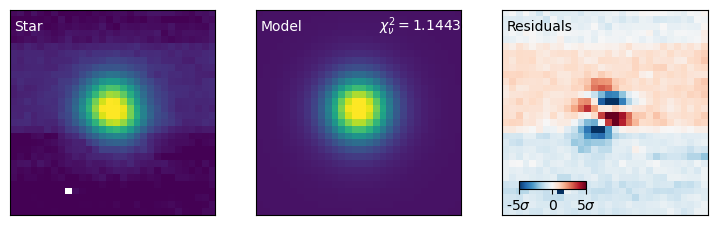

Star 4:
  x0 = 14.452
  y0 = 14.960
  amplitude = 1.031e+00
  FWHM = 4.277
  beta = 2.489
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [549000.4    403460.5    236976.02   122227.26    64388.453   34575.246
  19525.145   12429.458    7618.8706   4750.207    2570.2256   1068.9215
    637.4784   -626.426    -615.6431  -1815.3843  -2466.8894  -2721.7937
  -3275.6401  -3501.4915  -2592.637 ]
 
  fit_prof = [5.46068125e+05 4.01030875e+05 2.37626359e+05 1.22571664e+05
 6.25832539e+04 3.36666992e+04 1.88711406e+04 1.08447725e+04
 6.48728027e+03 4.02749854e+03 2.61243872e+03 1.73749939e+03
 1.19246484e+03 8.39968811e+02 6.01518921e+02 4.43689178e+02
 3.28436646e+02 2.51115402e+02 1.92254150e+02 1.47767548e+02
 1.20509705e+02]


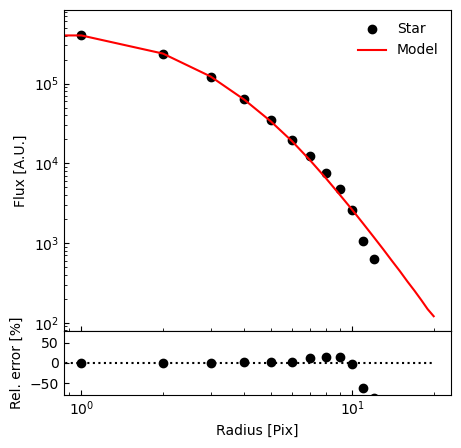

 
 
 
[[np.float64(3.152821365003753), np.float64(2.4170942798983)], [np.float64(4.282403187299805), np.float64(2.9415965002555104)], [np.float64(3.2184426093393124), np.float64(1.8157510791904257)], [np.float64(2.616492920074518), np.float64(2.2931013673871776)], [np.float64(4.277030256880463), np.float64(2.4888275609443453)]]


In [7]:
#white_img = np.nansum(cube, axis=0)
#white_img_err = np.sqrt(np.nansum(vcube, axis=0))

# x_to_mask = matched_positions_nocont[3][0]
# y_to_mask = matched_positions_nocont[3][1]

# y_axu, x_axu = np.ogrid[:white_img.shape[0], :white_img.shape[1]]
# nan_mask = (x_axu - x_to_mask-20)**2 + (y_axu - y_to_mask+6)**2 <= 8
# white_img[nan_mask] = np.nanmin(white_img)
# white_img_err[nan_mask] = np.nanmedian(white_img_err)


star_radec  = np.column_stack((matched_coords_nocont.ra.deg, matched_coords_nocont.dec.deg))

FHMW_Beta_list = []
flux_list = []
images_chi2 = []

annulus_background = False

for i, (ra, dec) in enumerate(star_radec):
    
    # Crear objeto SkyCoord con RA y Dec en grados
    coord = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs')


    # Definir el tamaño del recorte en pixeles
    cutout_size = 30
    #if i == len(star_radec) - 2:
    #    cutout_size = 80


    # Crear recorte en imagen de luz blanca
    cutout = Cutout2D(white_img, coord, size=cutout_size, 
                      wcs=wcs_2d, mode='partial', fill_value=0) 
    cutout_img = cutout.data
    cutout_wcs = cutout.wcs
    del cutout

    # Crear recorte en imagen de error
    aux = Cutout2D(white_img_err, coord, size=cutout_size, 
                   wcs=wcs_2d, mode='partial', fill_value=0) 
    cutout_img_err = aux.data
    del aux

    # -------------------------------------------------------------- #

    # Making the pixel grid that will used during the fit.
    szy, szx = np.shape(cutout_img)
    x, y = np.meshgrid(np.arange(szx), np.arange(szy))


    # Avoiding pixels with 0 or NaN values 
    mask = (cutout_img == 0) | (np.isnan(cutout_img))
    x_aux = x[~mask]
    y_aux = y[~mask]

    cutout_img_aux = cutout_img[~mask]
    cutout_img_err_aux = cutout_img_err[~mask]

    norm = np.nanmax(cutout_img_aux)

    cutout_img_aux /= norm
    cutout_img_err_aux /= norm 

    # Calculate background statistics for the cutout image and
    # subtract the background. I should add the background 
    # uncertainty to the error budget, but I am *not* doing this.
    
    if annulus_background:

        szy_an, szx_an = white_img.shape
        x_an, y_an = np.meshgrid(np.arange(szx_an), np.arange(szy_an))

        xcen = matched_positions_nocont[i][0]
        ycen = matched_positions_nocont[i][1]

        radius = np.sqrt( (x_an - xcen)**2 + (y_an - ycen)**2 )
        annulus = (radius > 17) & (radius < 25)

        _, median, std = sigma_clipped_stats(white_img[annulus], sigma=3.0)

        #-------------- -------------- -------------- -------------- --------------#
        fig, ax = plt.subplots(figsize=(5,5))
        minval = np.nanmin(white_img)
        p = np.nanpercentile(white_img - minval, [16, 99.5])

        col_norm = colors.LogNorm(vmin=p[0], vmax=p[1])

        im = ax.imshow(white_img - minval, origin='lower', norm=col_norm, cmap='viridis')
        ax.contour(annulus, colors='r', linewidths=0.8)

        # barra de color
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Flux [A.U.]")

        ax.set_title("Annulus region for background estimation")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(xcen-40,xcen+40)
        ax.set_ylim(ycen-40,ycen+40)

        plt.show()

        #-------------- -------------- -------------- -------------- --------------#
    else:
        _, median, std = sigma_clipped_stats(cutout_img, sigma=3.0)
        #std = np.nanstd(cutout_img_aux)

    cutout_img_corr = cutout_img - median

    #cutout_img_corr[cutout_img_corr<0] = 0  ############################################################

    # Setting the initial guesses and model the star
    guess = [cutout_size/2, cutout_size/2, np.nanmax(cutout_img_corr/norm), 2.4, 4]

    popt_psf, pcov_psf = curve_fit(moffat2D, 
                                   (x_aux, y_aux), 
                                   cutout_img_aux.ravel(), 
                                   p0=guess,
                                   absolute_sigma=True, 
                                   sigma=cutout_img_err_aux.ravel())
    

        
    FHMW_Beta_list.append(list(popt_psf[3:]))
    flux_list.append(popt_psf[2])



    # Obtain the best fit. Note that as I am fitting the auxiliar array
    # without zero values, I need to re-arrange the best-fit output to 
    # a 2D array following the cutout image size.
    fit_aux = moffat2D((x_aux, y_aux), *popt_psf)

    
    fit = cutout_img_corr*0
    #fit = np.full_like(cutout_img_corr, np.nan)

    
    fit[~mask] = fit_aux * norm
    
    residuals = (cutout_img_corr-fit) / std      # Residuals w.r.t. the image noise


    # Plotting images 
    chi_2 = do_imshow_plot(cutout_img_corr, fit, residuals, Npars=len(popt_psf), 
                                               mask=~mask)
    # Extracting radial profiles to provide better comparison
    radius =  np.sqrt((x-popt_psf[0])**2 + (y-popt_psf[1])**2) # circular apertures


    r_prof, img_prof, fit_prof = radial_prof(cutout_img_corr, 
                                             radius, 
                                             model=fit)
    
    print(f"Star {i}:")
    print(f"  x0 = {popt_psf[0]:.3f}")
    print(f"  y0 = {popt_psf[1]:.3f}")
    print(f"  amplitude = {popt_psf[2]:.3e}")
    print(f"  FWHM = {popt_psf[3]:.3f}")
    print(f"  beta = {popt_psf[4]:.3f}")
    print(" ")
    print("  r_prof =", r_prof)
    print(" ")
    print("  img_prof =", img_prof)
    print(" ")
    print("  fit_prof =", fit_prof)


    images_chi2.append(chi_2)

    # Plotting radial profile
    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.plot(r_prof, img_prof, 'ok', label='Star')
    ax.plot(r_prof, fit_prof, '-r', label='Model')
    
    ax.legend(frameon=False)  
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.tick_params(axis="both", direction="in", which='both')

    ax.set_ylabel('Flux [A.U.]')

    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="20%", pad=0)


    ax.figure.add_axes(ax2)
        
    ax2.plot(r_prof, 100*(1 - fit_prof/img_prof), 'ok')
    ax2.plot(r_prof, img_prof*0, ':k', linewidth=1.5)

    ax2.set_ylim([-79, 79])
    ax2.set_xscale('log')
    ax2.tick_params(axis="both", direction="in",which='both')
    
    ax2.set_ylabel('Rel. error [%]')
    ax2.set_xlabel('Radius [Pix]')
    
    plt.show()
    
    print(" ")
    print(" ")
    print(" ")

print(FHMW_Beta_list)

In [8]:
# índices deseados
indices = [0,1, 2, 3, 4]

# filtrar
sublista = [FHMW_Beta_list[i] for i in indices]

# separar valores
valores_1 = [par[0] for par in sublista]
valores_2 = [par[1] for par in sublista]

# estadísticos
prom_1 = np.mean(valores_1)
med_1 = np.median(valores_1)
std_1 = np.std(valores_1, ddof=1)

prom_2 = np.mean(valores_2)
med_2 = np.median(valores_2)
std_2 = np.std(valores_2, ddof=1)

print("FWHM:")
print(f"Promedio: {prom_1}")
print(f"Mediana: {med_1}")
print(f"Desviación estándar: {std_1}")

print("Beta:")
print(f"Promedio: {prom_2}")
print(f"Mediana: {med_2}")
print(f"Desviación estándar: {std_2}")

print("Flux: ", [float(flux_list[i]) for i in indices] )


FWHM:
Promedio: 3.5094380677195702
Mediana: 3.2184426093393124
Desviación estándar: 0.7409247112738886
Beta:
Promedio: 2.391274157535152
Mediana: 2.4170942798983
Desviación estándar: 0.40432126352865017
Flux:  [1.1243308434210697, 1.0164825156158743, 1.1363361592881809, 1.05144563855266, 1.0308727548603942]


## Fitting del quasar (whitelight image)

### Con imagenes normalidazas y psf de la estrella


x_peak y_peak peak_value
------ ------ ----------
    28     24  1008631.3
    32     25  1229902.2
    24     28  1404201.9
    30     29   883758.2
    30     40   353617.2
    26     50   24754.11
 peak_value
-----------
  0.7177807
 0.87524563
  0.9992839
  0.6289162
 0.25164756
0.017615974


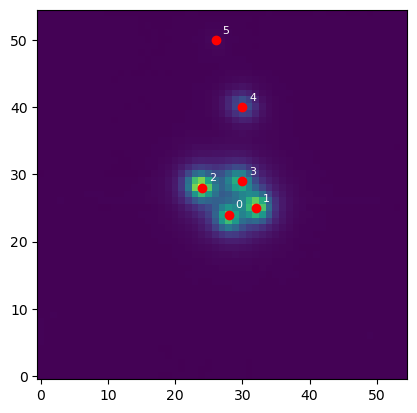

non_free:  0
non_free:  1
non_free:  2
non_free:  3
free:  4
free:  5


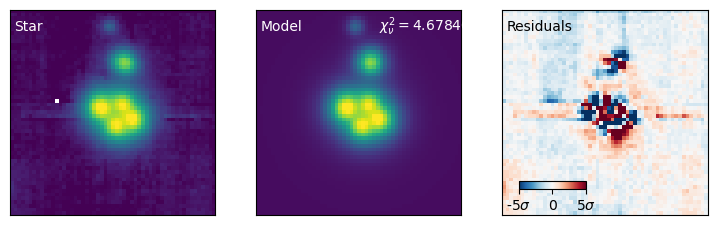

   Fuente          x          y     flujo      FWHM      beta
0       0  27.915178  23.564820  0.707927  3.152821  2.417094
1       1  32.149087  25.133603  0.861002  3.152821  2.417094
2       2  23.916787  28.158588  0.984585  3.152821  2.417094
3       3  29.498799  28.855041  0.645376  3.152821  2.417094
4       4  30.066303  40.171465  0.270305  3.245964  2.640502
5       5  26.047059  49.729678  0.017422  3.095415  5.701431


In [9]:
white_img = np.nansum(cube, axis=0)

ra, dec = 241.5013, - 23.5567      # Coordenadas del objeto (img. frame reference)

star_psf = FHMW_Beta_list[0]       # PSF MODEL SELECTION

cutout_size = 55    # in pixel units (Make cutout for the white-light image and its error image)


################ mask attemp ############## 

#y, x = np.ogrid[:white_img.shape[0], :white_img.shape[1]]
#nan_mask = (x - 240)**2 + (y - 225)**2 <= 0.5
#white_img[nan_mask] = np.nan 

#white_img[mask] = np.random.normal(loc=1000, scale=2000)
#white_img[mask] = np.random.normal(loc=-0.375138, scale=14.1206, size=white_img[mask].shape)

#-----------------------------------------#


coord = SkyCoord(ra, dec, unit='deg', frame='icrs')

cutout = Cutout2D(white_img, coord, size=cutout_size, 
                               wcs=wcs_2d,
                               mode='partial', 
                               fill_value=0) 
qso_img = cutout.data
qso_wcs = cutout.wcs
del cutout

aux = Cutout2D(white_img_err, coord, size=cutout_size,
                                wcs=wcs_2d,
                                mode='partial', 
                                fill_value=0) 
qso_img_err = aux.data
del aux

# Making the pixel grid that will used during the fit.
szy, szx = np.shape(qso_img)
x, y = np.meshgrid(np.arange(szx), np.arange(szy))

# Calculate background statistics for the cutout image and
# find how may sources are within this image. Note that the
# flux threshold used for define a "significant detection" 
# depends on the noise level of the image. Here, I use the
# photutils.find_peaks routine 



# Avoiding pixels with 0 or NaN values 
mask = (qso_img == 0) | (np.isnan(qso_img))
x_aux = x[~mask]
y_aux = y[~mask]

qso_img_aux = qso_img[~mask]
qso_img_err_aux = qso_img_err[~mask]

norm = np.nanmax(qso_img_aux)


qso_img_aux /= norm
qso_img_err_aux /= norm 



mean, median, std = sigma_clipped_stats(qso_img, sigma=3.0)
#mean, median, std = sigma_clipped_stats(qso_img_aux*norm, sigma=3.0)

qso_img -= median  # rough background subtraction


threshold = 5* std                # Threshold for peak detection
tbl = find_peaks(qso_img, threshold, box_size=5)

xpeak, ypeak, peakval = tbl['x_peak'], tbl['y_peak'], tbl['peak_value']

print(tbl[["x_peak", "y_peak", "peak_value"]])
print(peakval/norm)


Nsources = len(xpeak)

# Visualización rápida
plt.imshow(qso_img, origin='lower')
plt.plot(xpeak, ypeak, 'or')
for i in range(Nsources):
    plt.text(xpeak[i] + 1, ypeak[i] + 1, str(i), color='white', fontsize=8)
plt.show()

# Construcción de parámetros iniciales y límites
guess, up_bounds, lo_bounds = [], [], []

for i in range(Nsources):
    if peakval[i]/norm < 0.3:   #0.3 deja qso fijo a psf y otros free; 0:all_non_free
        print("free: ", i)
        guess += [xpeak[i], ypeak[i], peakval[i]/norm] + list(popt_psf[3:])
        up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.5*peakval[i]/norm, 50.0, 50.0]
        lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0.01*peakval[i]/norm, 0.001, 0.001]
    else:
        print("non_free: ", i)
        guess += [xpeak[i], ypeak[i], peakval[i]/norm] + list(star_psf)
        up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.2*peakval[i]/norm] + [x * 1.00000001 for x in star_psf]
        lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0] + [x * 0.999999999 for x in star_psf]


# Ajuste con modelo Moffat múltiple
popt, pcov = curve_fit(lens_qso_fit,
                       (x, y),
                       qso_img_aux.ravel(),
                       p0=guess,
                       sigma=qso_img_err_aux.ravel(),
                       bounds=(lo_bounds, up_bounds)
                       )

# Evaluación del modelo y visualización
fit_aux = lens_qso_fit((x, y), *popt)
fit = np.zeros_like(qso_img)
fit[~mask] = fit_aux * norm  # se escala el modelo a la imagen original

residuals = (qso_img - fit) / std  # residuo en unidades de sigma

# Gráfico final
do_imshow_plot(qso_img, fit, residuals, Npars=len(popt))

# Construcción de tabla con parámetros
param_list = []
for i in range(Nsources):
    param_list.append({
        "Fuente": i,
        "x": popt[i*5 + 0],
        "y": popt[i*5 + 1],
        "flujo": popt[i*5 + 2],
        "FWHM": popt[i*5 + 3],
        "beta": popt[i*5 + 4]
    })

df = pd.DataFrame(param_list)
print(df)

# 1 2 0 3

rangos con parametros libres (no PSF based):  -------   FWHM = [3, 3.3] ------ Beta = [2.19, 3.2] ------

# Go trought wavelenght (Start test)

In [11]:
import warnings
from scipy.optimize import OptimizeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=OptimizeWarning)


## Multiframe

### test - Normalized

In [12]:
print(FHMW_Beta_list)

[[np.float64(3.152821365003753), np.float64(2.4170942798983)], [np.float64(4.282403187299805), np.float64(2.9415965002555104)], [np.float64(3.2184426093393124), np.float64(1.8157510791904257)], [np.float64(2.616492920074518), np.float64(2.2931013673871776)], [np.float64(4.277030256880463), np.float64(2.4888275609443453)]]


<SkyCoord (ICRS): (ra, dec) in deg
    (241.49299156, -23.54594423)>
param: 12.06447273, bounds: [10.0, 20.0], in bounds: True
param: 11.84000283, bounds: [10.0, 20.0], in bounds: True
param: 1.07655817, bounds: [0.8246982038883154, 1.5463091322905913], in bounds: True
param: 3.26052643, bounds: [3.4216242055043704, 6.415545385320694], in bounds: False
param: 2.66879, bounds: [1.9910620487554764, 3.7332413414165178], in bounds: True
[0,50]


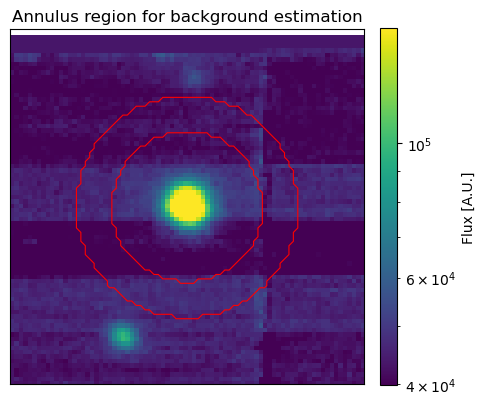

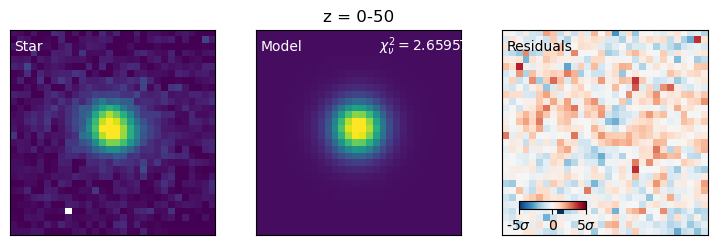

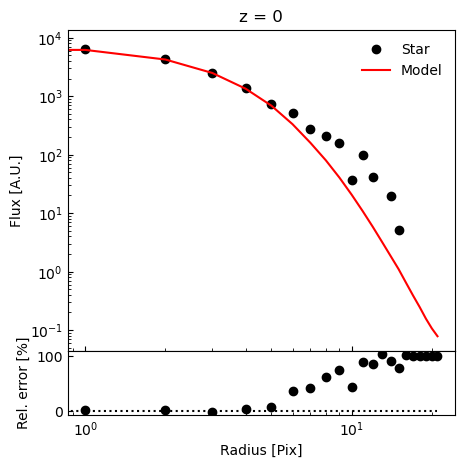

  x0 = 14.344
  y0 = 15.099
  amplitude = 9.989e-01
  FWHM = 5.276
  beta = 4.859
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]
 
  img_prof = [ 7.64624072e+03  6.31654346e+03  4.34306885e+03  2.45354272e+03
  1.40425928e+03  7.38345398e+02  5.21706787e+02  2.74237946e+02
  2.08582016e+02  1.55840607e+02  3.64261208e+01  9.93574982e+01
  4.13346024e+01 -8.71104507e+01  1.97008438e+01  5.17812777e+00
 -4.55900230e+01 -8.34704514e+01 -1.07336235e+02 -1.48360489e+02
 -1.68490158e+02 -2.55751862e+02]
 
  fit_prof = [7.6348179e+03 6.1952930e+03 4.2408701e+03 2.4962207e+03 1.3436021e+03
 6.8726459e+02 3.3188519e+02 1.5962576e+02 8.0041252e+01 4.0406391e+01
 2.0650171e+01 1.0815570e+01 5.8325682e+00 3.2209926e+00 1.8478243e+00
 1.1012720e+00 6.4215499e-01 3.8888770e-01 2.4684829e-01 1.5610364e-01
 1.0634176e-01 7.8166373e-02]
     
     
[200,250]


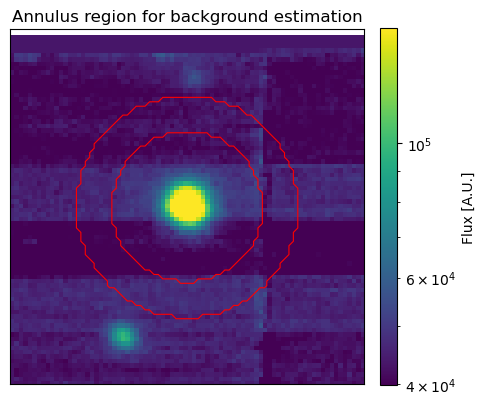

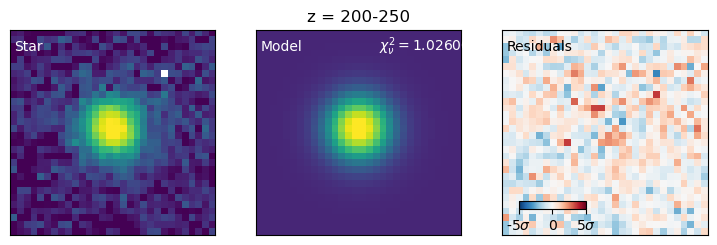

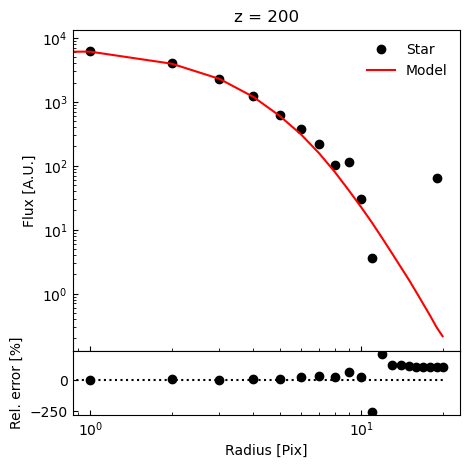

  x0 = 14.478
  y0 = 15.092
  amplitude = 1.014e+00
  FWHM = 5.034
  beta = 4.101
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 7.84813477e+03  6.11862354e+03  4.09071240e+03  2.26412817e+03
  1.24065332e+03  6.22890076e+02  3.74590576e+02  2.18569931e+02
  1.02077225e+02  1.15680367e+02  3.00174408e+01  3.57667828e+00
 -6.96579409e+00 -3.54387321e+01 -1.36769171e+01 -3.75307961e+01
 -3.73856239e+01 -4.96056404e+01 -7.61953278e+01  6.36168823e+01
 -1.63854309e+02]
 
  fit_prof = [7.8213359e+03 6.0782651e+03 3.9377495e+03 2.2805208e+03 1.1937227e+03
 6.0441663e+02 3.0931677e+02 1.5661212e+02 7.9950493e+01 4.1487526e+01
 2.2593061e+01 1.2700196e+01 7.2523847e+00 4.2948871e+00 2.6179552e+00
 1.6601757e+00 1.0517575e+00 6.8017191e-01 4.4960949e-01 2.9859918e-01
 2.1520418e-01]
     
     
[400,450]


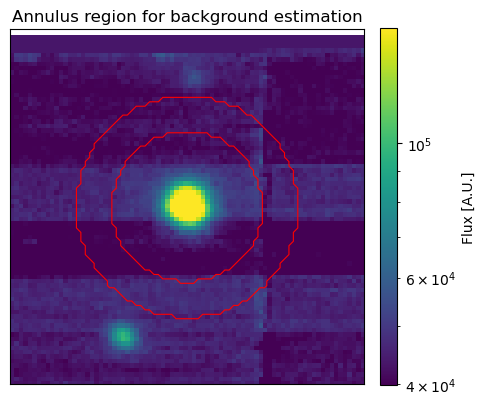

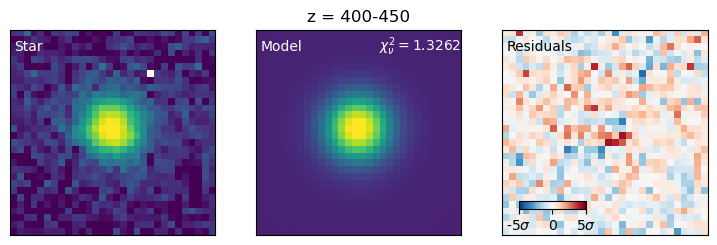

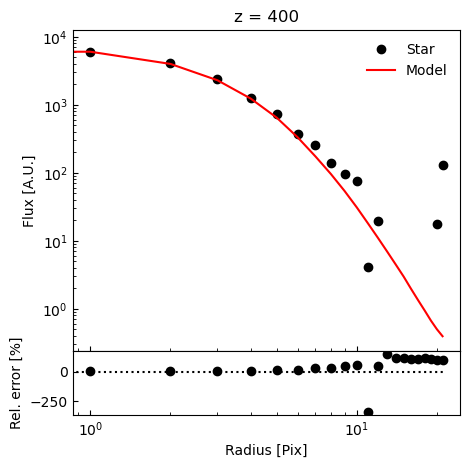

  x0 = 14.324
  y0 = 15.087
  amplitude = 9.710e-01
  FWHM = 4.994
  beta = 3.564
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]
 
  img_prof = [ 7.6731753e+03  6.0420483e+03  4.1365610e+03  2.3526831e+03
  1.2667739e+03  7.1953174e+02  3.6514200e+02  2.5562561e+02
  1.3907179e+02  9.4621292e+01  7.5377136e+01  4.0735078e+00
  1.9661072e+01 -1.3480816e+01 -2.9121544e+01 -2.0106314e+01
 -2.3484293e+01 -3.9073650e+01 -6.3815064e+00 -2.2152916e+01
  1.7523146e+01  1.2876085e+02]
 
  fit_prof = [7.6094321e+03 6.0211602e+03 3.9819531e+03 2.2909963e+03 1.2313169e+03
 6.4827594e+02 3.3164011e+02 1.7331912e+02 9.5483604e+01 5.3841545e+01
 3.0922483e+01 1.8119715e+01 1.1037142e+01 6.9251728e+00 4.4650702e+00
 2.9569960e+00 1.9442416e+00 1.3260436e+00 9.3306959e-01 6.6261065e-01
 4.9545512e-01 3.9112082e-01]
     
     
[600,650]


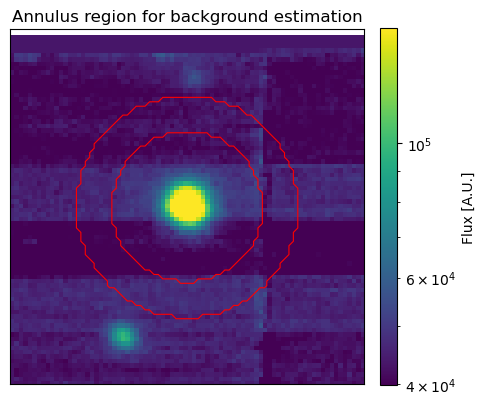

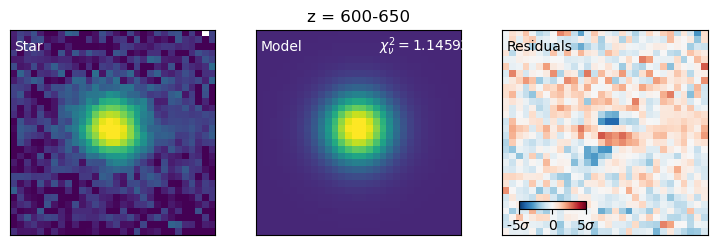

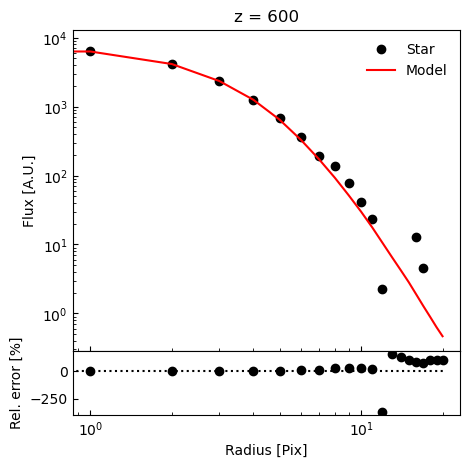

  x0 = 14.378
  y0 = 15.034
  amplitude = 1.017e+00
  FWHM = 4.960
  beta = 3.577
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 7.9335049e+03  6.3074688e+03  4.2143711e+03  2.3527222e+03
  1.2518674e+03  6.7574384e+02  3.6684338e+02  1.9393481e+02
  1.3891101e+02  7.7778130e+01  4.1345615e+01  2.3321957e+01
  2.2331331e+00 -1.0861249e+01 -1.5167417e+01 -5.0371487e+01
  1.2713870e+01  4.5391979e+00 -4.1465462e+01 -1.4126352e+02
 -7.9203568e+01]
 
  fit_prof = [7.9478345e+03 6.3085244e+03 4.1499331e+03 2.3463547e+03 1.2587888e+03
 6.4737317e+02 3.2897766e+02 1.7200784e+02 9.3054581e+01 5.1835926e+01
 2.9996637e+01 1.7684097e+01 1.0567418e+01 6.5798564e+00 4.2724075e+00
 2.8415620e+00 1.8790872e+00 1.2718486e+00 8.9081961e-01 6.3194728e-01
 4.6696681e-01]
     
     
[800,850]


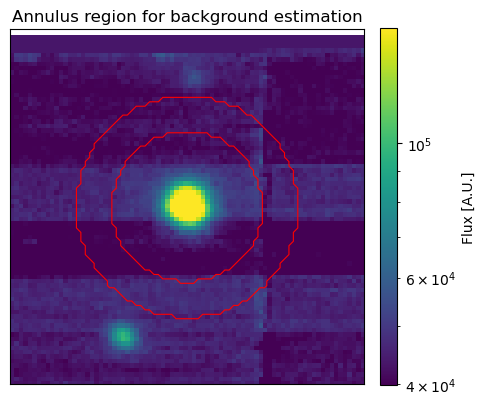

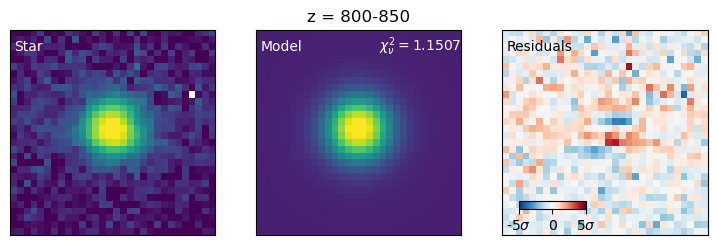

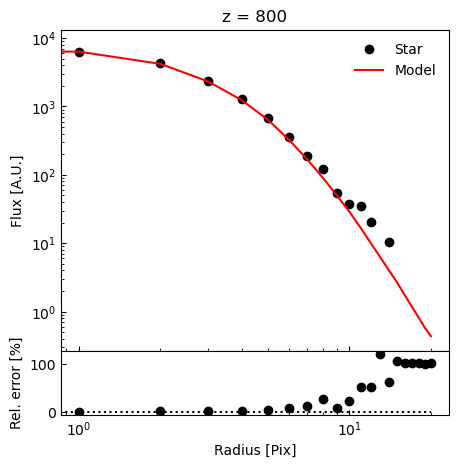

  x0 = 14.397
  y0 = 14.998
  amplitude = 1.023e+00
  FWHM = 4.891
  beta = 3.568
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [7986.6025   6323.501    4265.3506   2374.8274   1268.6725    670.7524
  352.17288   188.99603   121.70516    53.81817    37.3264     34.68735
   20.407469  -29.68875    10.456842  -50.68101   -77.797585  -74.219345
  -74.61265  -148.3118    -60.10667 ]
 
  fit_prof = [8.0070815e+03 6.3156650e+03 4.1859395e+03 2.3263108e+03 1.2343516e+03
 6.3919226e+02 3.2065515e+02 1.6629669e+02 8.9196205e+01 4.9681396e+01
 2.8825516e+01 1.6783514e+01 1.0032286e+01 6.2272868e+00 4.0082765e+00
 2.6646304e+00 1.7494519e+00 1.1802484e+00 8.2733011e-01 5.8106816e-01
 4.3735886e-01]
     
     
[1000,1050]


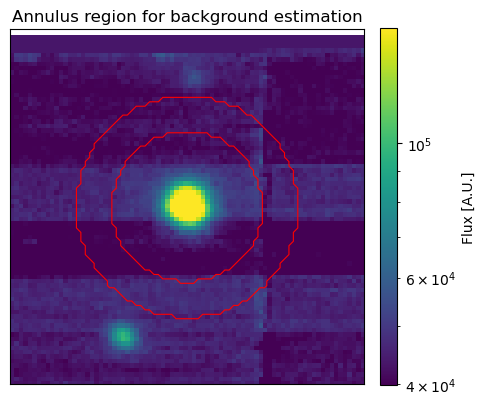

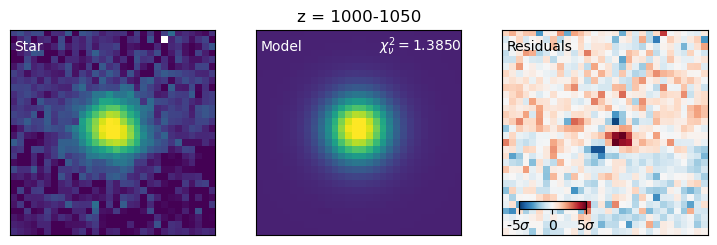

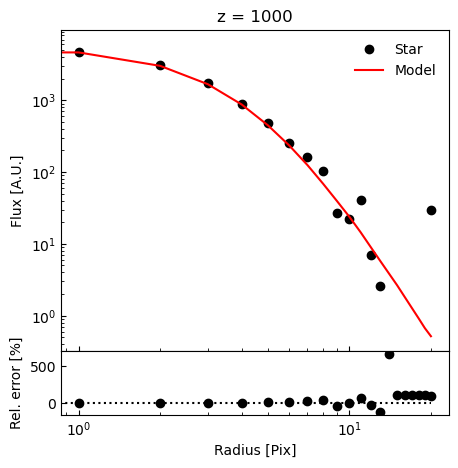

  x0 = 14.370
  y0 = 14.986
  amplitude = 1.035e+00
  FWHM = 4.748
  beta = 3.208
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 5.93602246e+03  4.69785449e+03  3.08910498e+03  1.72084924e+03
  8.90014587e+02  4.85109558e+02  2.56468567e+02  1.61207581e+02
  1.04382095e+02  2.72488441e+01  2.24944267e+01  4.10509224e+01
  6.95411301e+00  2.56584311e+00 -6.77442014e-01 -1.87993851e+01
 -4.80171585e+01 -1.64676628e+01 -2.79933033e+01 -7.41353683e+01
  2.91974277e+01]
 
  fit_prof = [5.9574189e+03 4.6316855e+03 3.0107170e+03 1.6714172e+03 8.7219043e+02
 4.4721585e+02 2.3331827e+02 1.2478112e+02 6.8430870e+01 3.9329941e+01
 2.3748541e+01 1.4481264e+01 8.9514484e+00 5.7642579e+00 3.8541536e+00
 2.6497602e+00 1.8202931e+00 1.2805778e+00 9.1977966e-01 6.6802555e-01
 5.1616186e-01]
     
     
[1200,1250]


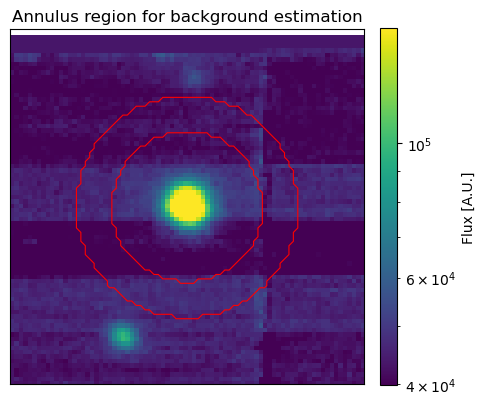

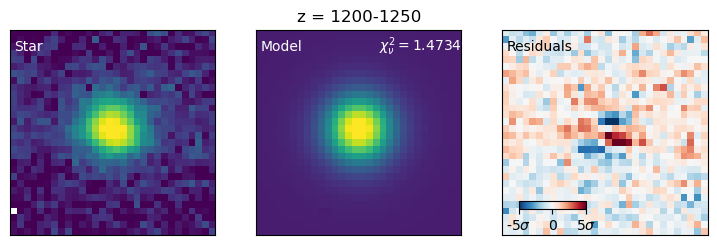

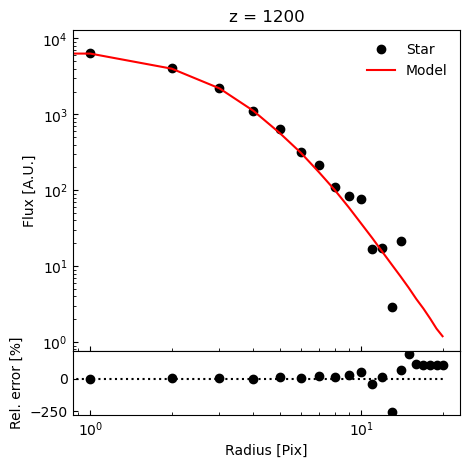

  x0 = 14.481
  y0 = 14.973
  amplitude = 1.031e+00
  FWHM = 4.562
  beta = 2.835
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 8.31038477e+03  6.35701270e+03  4.07916553e+03  2.23808569e+03
  1.11158496e+03  6.43142517e+02  3.18770020e+02  2.17547363e+02
  1.11087685e+02  8.45027847e+01  7.61341934e+01  1.69160175e+01
  1.75415630e+01  2.90629363e+00  2.15061226e+01 -5.59969997e+00
 -3.36722183e+01 -4.12174683e+01 -9.60110321e+01 -2.05418549e+01
 -4.49909210e+01]
 
  fit_prof = [8.3147051e+03 6.3261279e+03 4.0005215e+03 2.2022834e+03 1.1166367e+03
 5.7152533e+02 3.1083630e+02 1.7233342e+02 1.0069141e+02 5.9867317e+01
 3.6652584e+01 2.3491692e+01 1.5382376e+01 1.0438500e+01 7.3149695e+00
 5.1951690e+00 3.6940873e+00 2.7620790e+00 2.0413465e+00 1.5040841e+00
 1.1949652e+00]
     
     
[1400,1450]


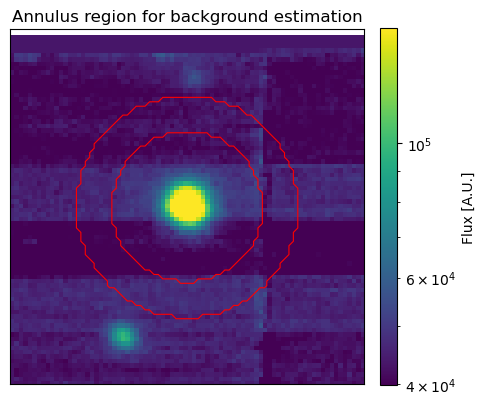

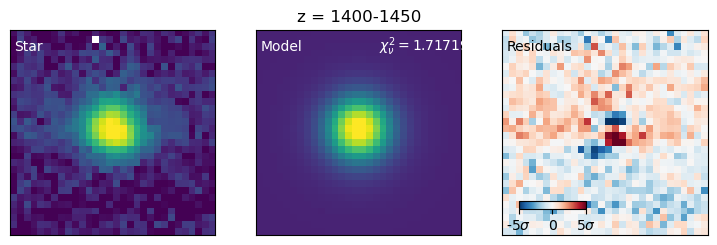

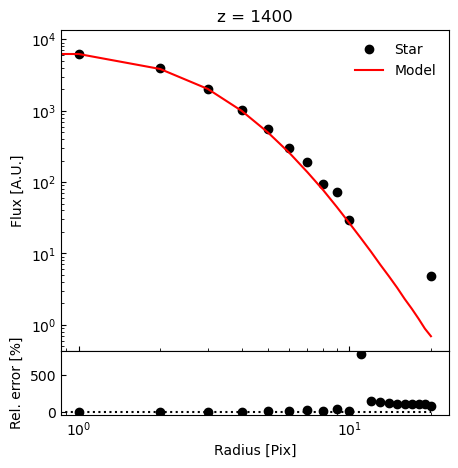

  x0 = 14.474
  y0 = 14.976
  amplitude = 1.022e+00
  FWHM = 4.429
  beta = 3.021
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 8.4486270e+03  6.2500508e+03  3.9033914e+03  2.0187716e+03
  1.0299460e+03  5.5348193e+02  3.0381165e+02  1.8887604e+02
  9.5348679e+01  7.3598686e+01  2.8975346e+01 -2.4247310e+00
 -1.9697353e+01 -1.6873072e+01 -3.0957561e+01 -2.2523197e+01
 -6.6194572e+01 -7.9765762e+01 -4.8670086e+01 -5.4565163e+01
  4.8077717e+00]
 
  fit_prof = [8.3075781e+03 6.2312969e+03 3.8430171e+03 2.0165861e+03 9.9531952e+02
 4.9615363e+02 2.5685687e+02 1.3722391e+02 7.7184807e+01 4.4378426e+01
 2.6551155e+01 1.6541460e+01 1.0640052e+01 6.9567080e+00 4.7705770e+00
 3.3142617e+00 2.2996395e+00 1.6765684e+00 1.2175790e+00 8.8292283e-01
 6.9105601e-01]
     
     
[1600,1650]


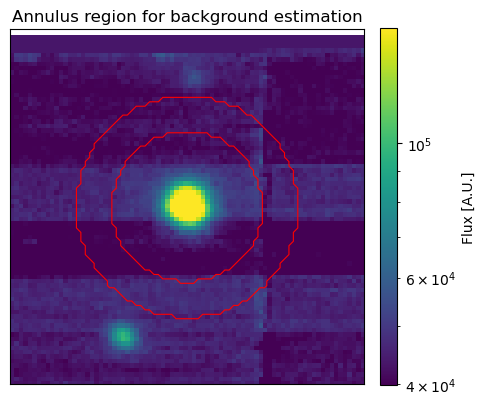

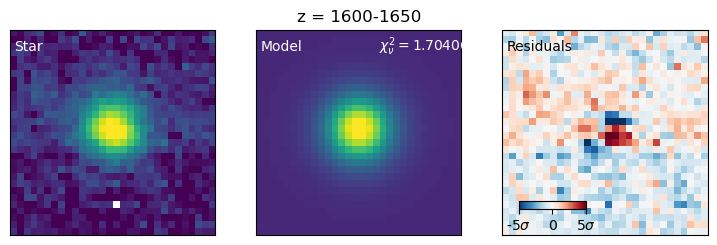

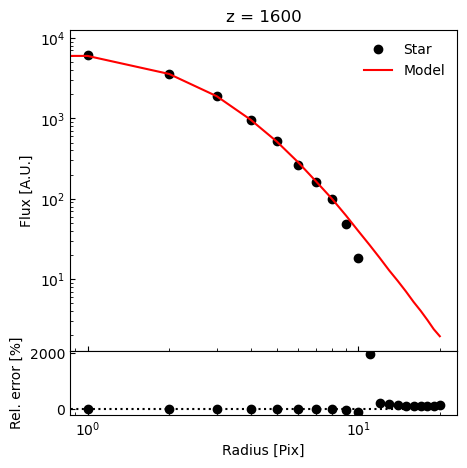

  x0 = 14.499
  y0 = 14.990
  amplitude = 1.010e+00
  FWHM = 4.201
  beta = 2.421
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 8.2835332e+03  6.1287461e+03  3.5950149e+03  1.8753746e+03
  9.6133612e+02  5.1868579e+02  2.6192407e+02  1.6301595e+02
  9.8529549e+01  4.8733578e+01  1.8245621e+01 -1.4294190e+00
 -1.9131449e+01 -1.4631505e+01 -1.8567955e+01 -6.6988304e+01
 -5.7886303e+01 -6.9036507e+01 -4.2595352e+01 -2.5407827e+01
 -9.4588728e+00]
 
  fit_prof = [8.2369111e+03 5.9853218e+03 3.5723743e+03 1.8880050e+03 9.6415753e+02
 5.1530695e+02 2.8386563e+02 1.6297108e+02 9.9718018e+01 6.2104958e+01
 3.9747063e+01 2.6717794e+01 1.8383936e+01 1.2871535e+01 9.4766588e+00
 7.0251918e+00 5.2162628e+00 4.0387225e+00 3.1056881e+00 2.3842010e+00
 1.9516118e+00]
     
     
[1800,1850]


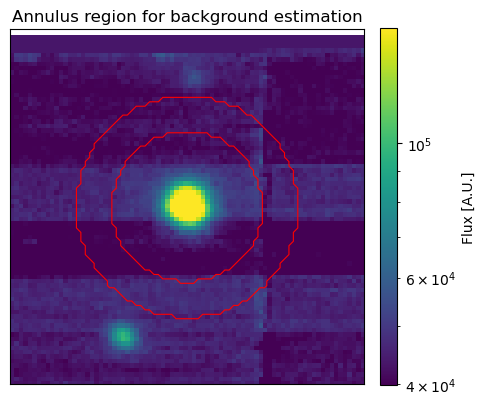

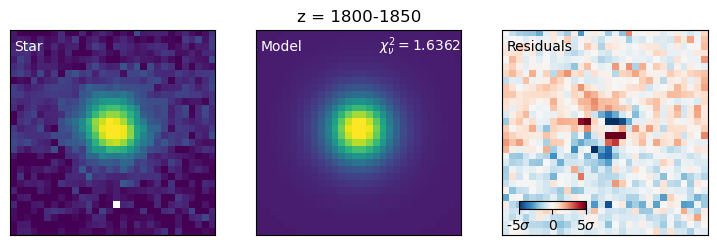

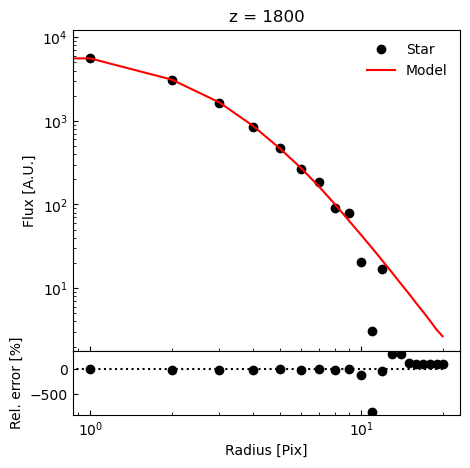

  x0 = 14.512
  y0 = 14.928
  amplitude = 1.046e+00
  FWHM = 4.068
  beta = 2.234
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 8.1778047e+03  5.6231821e+03  3.0930916e+03  1.6446508e+03
  8.5318488e+02  4.7625922e+02  2.6836127e+02  1.8600177e+02
  8.9635925e+01  7.9824272e+01  2.0346651e+01  3.0681102e+00
  1.7032978e+01 -7.1626730e+00 -5.0643082e+00 -2.1428421e+01
 -3.0981670e+01 -3.8007488e+01 -2.8229755e+01 -2.8581518e+01
 -1.9120548e+01]
 
  fit_prof = [8.1696025e+03 5.5849556e+03 3.1159812e+03 1.6604908e+03 8.6644727e+02
 4.7117804e+02 2.7326202e+02 1.6345526e+02 1.0099038e+02 6.4609245e+01
 4.3324120e+01 2.9969688e+01 2.1199915e+01 1.5403390e+01 1.1369529e+01
 8.6297531e+00 6.5666790e+00 5.1514106e+00 4.0436192e+00 3.1891534e+00
 2.6552505e+00]
     
     
[2000,2050]


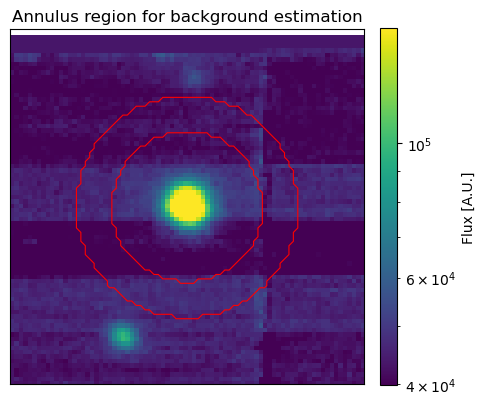

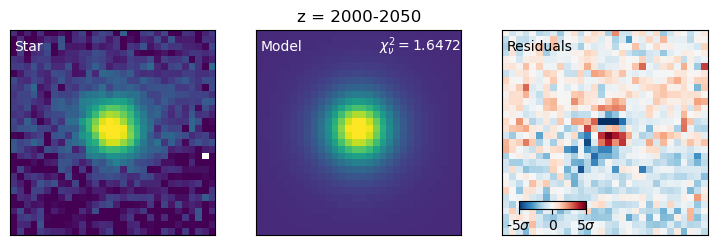

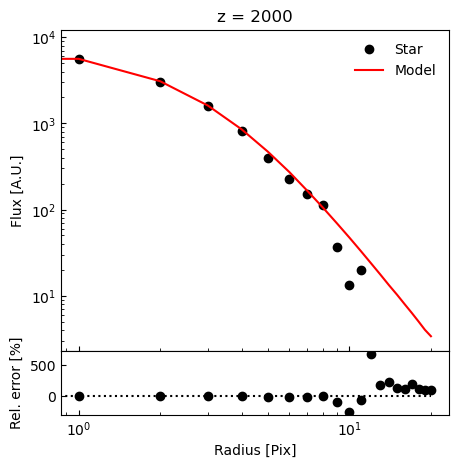

  x0 = 14.438
  y0 = 14.928
  amplitude = 1.045e+00
  FWHM = 3.938
  beta = 2.090
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 8.2216514e+03  5.6361821e+03  3.0288723e+03  1.5789100e+03
  8.1935309e+02  3.9827499e+02  2.2764755e+02  1.4946715e+02
  1.1271014e+02  3.7186329e+01  1.3342546e+01  1.9753668e+01
 -4.1287498e+00 -2.3651306e+01 -1.0551190e+01 -4.1947876e+01
 -3.5363235e+01 -7.1651902e+00 -6.3889286e+01 -7.8022507e+01
 -5.1199509e+01]
 
  fit_prof = [8.2213105e+03 5.6134136e+03 3.0854714e+03 1.6114727e+03 8.5215131e+02
 4.6880121e+02 2.7208151e+02 1.6415292e+02 1.0440664e+02 6.8906090e+01
 4.7174183e+01 3.3154186e+01 2.3867134e+01 1.7617865e+01 1.3219858e+01
 1.0229324e+01 7.9468908e+00 6.2954764e+00 5.0110850e+00 4.0120306e+00
 3.3776047e+00]
     
     
[2200,2250]


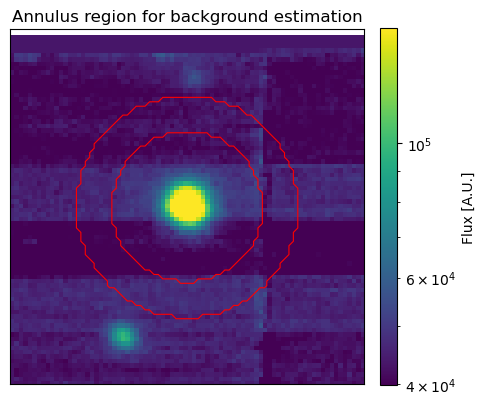

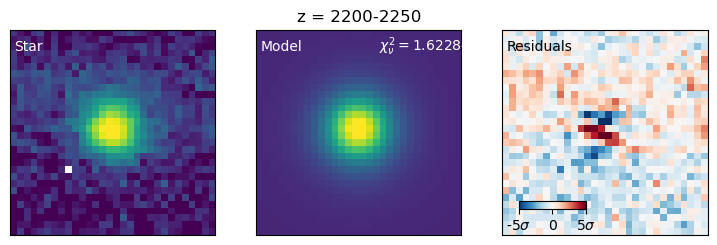

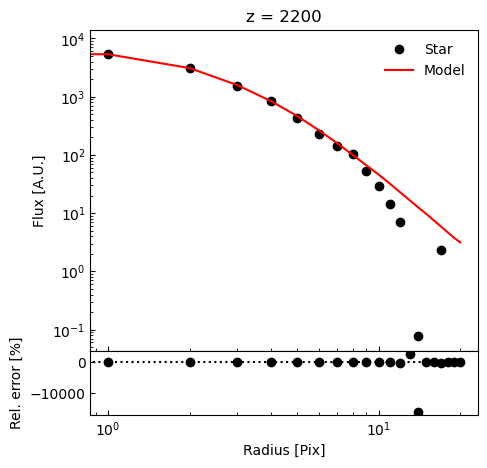

  x0 = 14.357
  y0 = 14.998
  amplitude = 9.716e-01
  FWHM = 3.986
  beta = 2.105
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 7.8472207e+03  5.4549258e+03  3.1185454e+03  1.5297080e+03
  8.3832349e+02  4.3247830e+02  2.2983987e+02  1.4432721e+02
  1.0373353e+02  5.1977295e+01  2.9701420e+01  1.4495406e+01
  7.1456604e+00 -6.3560867e-01  7.6801650e-02 -3.9810253e+01
 -1.6940327e+01  2.3579648e+00 -6.2835228e+01 -7.8082535e+01
 -1.5586677e+01]
 
  fit_prof = [7.5995010e+03 5.3549058e+03 3.0966504e+03 1.5831835e+03 8.3639703e+02
 4.6321893e+02 2.6555603e+02 1.6014555e+02 1.0030797e+02 6.6095306e+01
 4.5579861e+01 3.1883118e+01 2.2732790e+01 1.6642687e+01 1.2498455e+01
 9.6432018e+00 7.4346251e+00 5.8333039e+00 4.6509829e+00 3.7475643e+00
 3.1429181e+00]
     
     
[2400,2450]


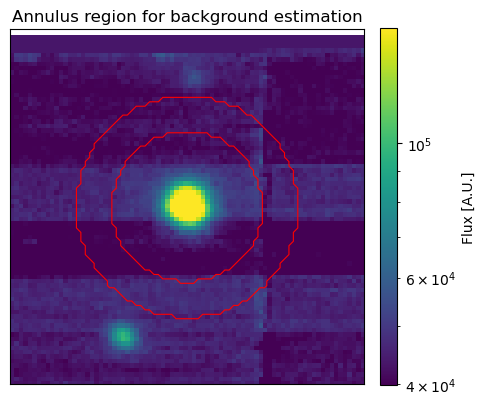

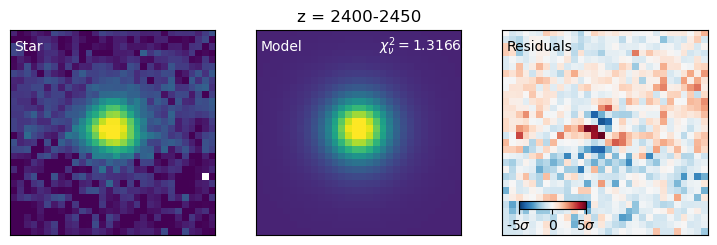

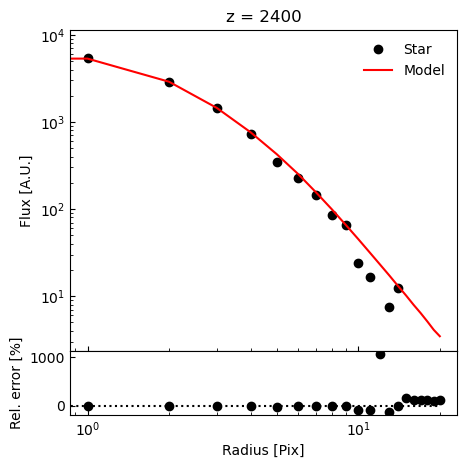

  x0 = 14.467
  y0 = 14.950
  amplitude = 1.066e+00
  FWHM = 3.865
  beta = 2.029
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 7.5070107e+03  5.4288921e+03  2.8818306e+03  1.4545060e+03
  7.3463043e+02  3.5107205e+02  2.2659962e+02  1.4421503e+02
  8.4514854e+01  6.5450043e+01  2.4150896e+01  1.6436031e+01
 -2.4029303e+00  7.4646883e+00  1.2345314e+01 -1.8949526e+01
 -3.2349781e+01 -6.6033295e+01 -3.2328472e+01 -7.8994858e+01
 -6.1467590e+01]
 
  fit_prof = [7.7413604e+03 5.3400913e+03 2.8973882e+03 1.4515291e+03 7.6237903e+02
 4.2604529e+02 2.5180646e+02 1.5403842e+02 9.8676674e+01 6.5504906e+01
 4.5098911e+01 3.1922224e+01 2.3252092e+01 1.7357668e+01 1.3134393e+01
 1.0197923e+01 7.9479790e+00 6.3736491e+00 5.1029682e+00 4.0948262e+00
 3.4606199e+00]
     
     
[2600,2650]


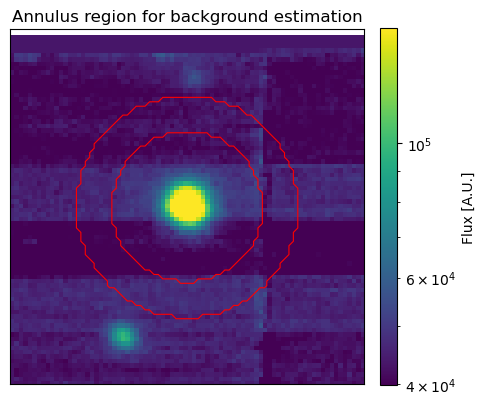

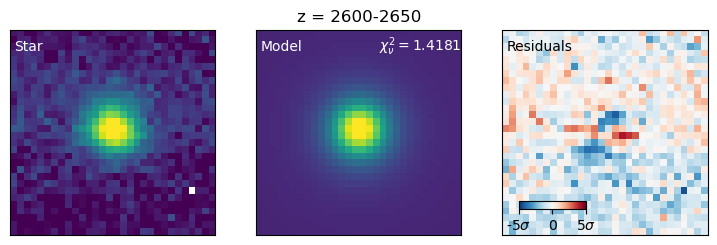

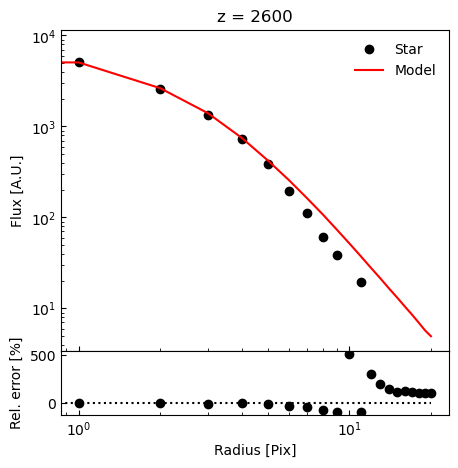

  x0 = 14.565
  y0 = 14.913
  amplitude = 1.063e+00
  FWHM = 3.667
  beta = 1.842
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [7684.165    5081.187    2548.723    1341.733     723.9956    386.34888
  192.8071    112.27337    61.250072   38.33298   -12.381187   19.363726
  -13.349158  -21.658178  -38.684513  -62.07502   -47.729202  -44.009747
  -77.22887  -106.198074 -122.929344]
 
  fit_prof = [7.9467607e+03 5.0586733e+03 2.6352429e+03 1.4005474e+03 7.5020245e+02
 4.2208917e+02 2.5427023e+02 1.6064594e+02 1.0665656e+02 7.2956665e+01
 5.1685436e+01 3.7588421e+01 2.7950968e+01 2.1396763e+01 1.6565554e+01
 1.3157287e+01 1.0520236e+01 8.5733633e+00 6.9982214e+00 5.7479568e+00
 4.9358253e+00]
     
     
[2800,2850]


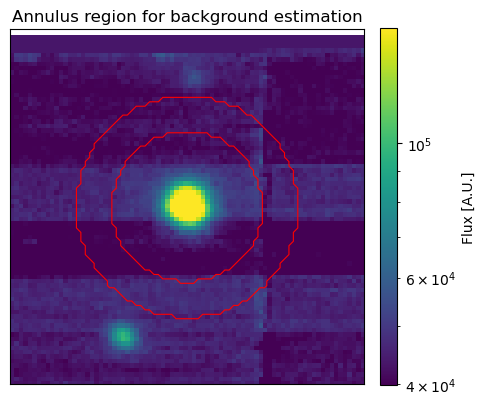

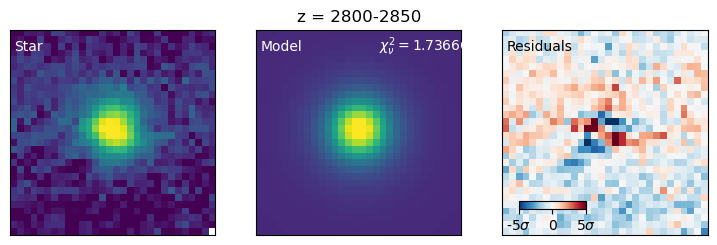

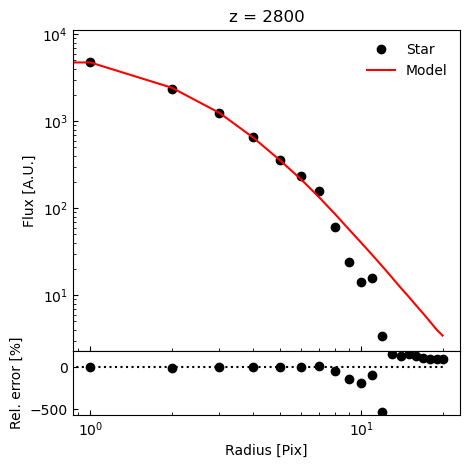

  x0 = 14.521
  y0 = 14.916
  amplitude = 1.036e+00
  FWHM = 3.625
  beta = 1.935
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 7.60764258e+03  4.81761523e+03  2.36622876e+03  1.25450244e+03
  6.64404114e+02  3.58107605e+02  2.33327957e+02  1.56777130e+02
  6.12502098e+01  2.39641857e+01  1.41750355e+01  1.56598043e+01
  3.37556386e+00 -2.51776028e+01 -2.95702171e+01 -1.53711624e+01
 -2.04221344e+01 -3.54352226e+01 -8.04131470e+01 -7.77832718e+01
 -1.08346054e+02]
 
  fit_prof = [7.5130039e+03 4.7394526e+03 2.4271531e+03 1.2458905e+03 6.4721100e+02
 3.5929083e+02 2.1503885e+02 1.3369971e+02 8.6201675e+01 5.7578007e+01
 4.0250259e+01 2.9025723e+01 2.1356979e+01 1.6017809e+01 1.2203416e+01
 9.5953894e+00 7.5850368e+00 6.1103811e+00 4.9426546e+00 4.0308146e+00
 3.4350262e+00]
     
     
[3000,3050]


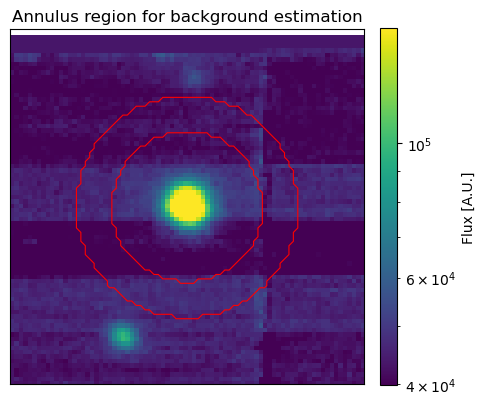

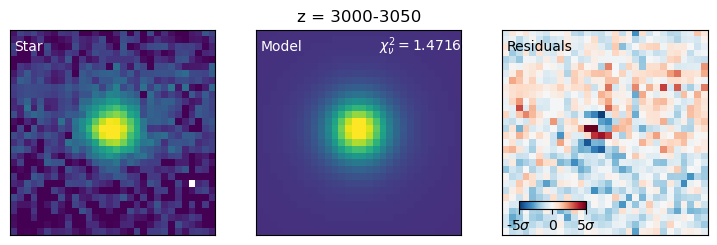

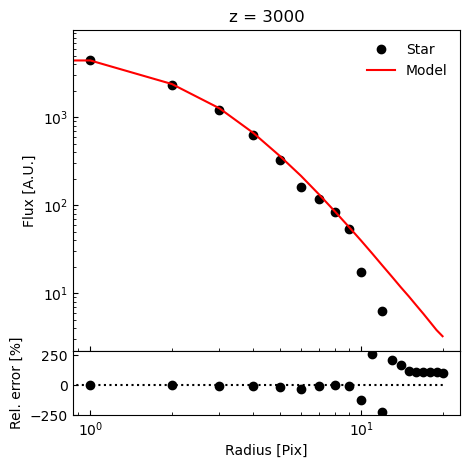

  x0 = 14.412
  y0 = 14.886
  amplitude = 1.073e+00
  FWHM = 3.748
  beta = 1.975
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 6.67525635e+03  4.45471729e+03  2.31105347e+03  1.19689758e+03
  6.27545715e+02  3.22102509e+02  1.60057846e+02  1.17355843e+02
  8.46876984e+01  5.38683815e+01  1.75975895e+01 -1.73639488e+01
  6.27863836e+00 -1.41530075e+01 -1.75014496e+01 -4.45905609e+01
 -6.13841896e+01 -8.83706894e+01 -8.56746521e+01 -5.67533569e+01
 -6.77695007e+01]
 
  fit_prof = [6.6664067e+03 4.4055933e+03 2.3813149e+03 1.2603574e+03 6.6202197e+02
 3.6482852e+02 2.1555354e+02 1.3238655e+02 8.5185425e+01 5.7146420e+01
 3.9694923e+01 2.8270575e+01 2.0601652e+01 1.5454281e+01 1.1784166e+01
 9.2485838e+00 7.2888336e+00 5.8405595e+00 4.7004466e+00 3.8242919e+00
 3.2529392e+00]
     
     
[3200,3250]


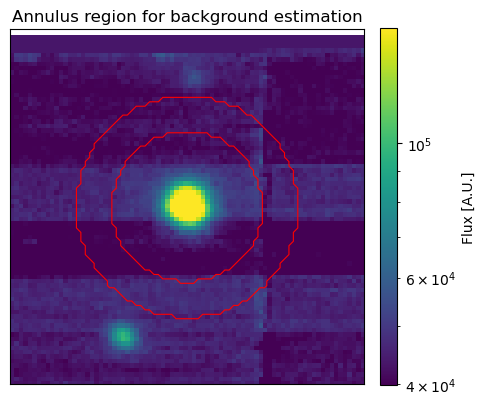

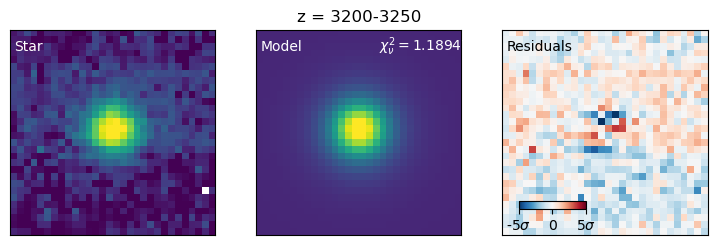

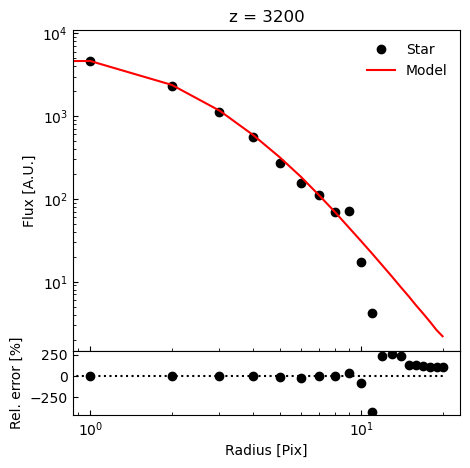

  x0 = 14.543
  y0 = 14.932
  amplitude = 1.007e+00
  FWHM = 3.652
  beta = 2.086
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 7.2945498e+03  4.5884697e+03  2.3337275e+03  1.1105144e+03
  5.6436316e+02  2.7438910e+02  1.5354332e+02  1.1054560e+02
  6.8437920e+01  7.0641289e+01  1.7343925e+01  4.1416116e+00
 -1.2130541e+01 -7.2440929e+00 -6.5104976e+00 -3.0144325e+01
 -2.2680168e+01 -3.4032871e+01 -4.4923412e+01 -6.4063759e+01
 -5.4315910e+01]
 
  fit_prof = [7.12093555e+03 4.61612793e+03 2.37649561e+03 1.16313513e+03
 5.87874573e+02 3.19233826e+02 1.84280701e+02 1.10442406e+02
 6.96005783e+01 4.53609581e+01 3.09199448e+01 2.17311974e+01
 1.56347380e+01 1.15363188e+01 8.64111423e+00 6.64476442e+00
 5.13021278e+00 4.07716560e+00 3.25608373e+00 2.60501337e+00
 2.19218564e+00]
     
     
[3400,3450]


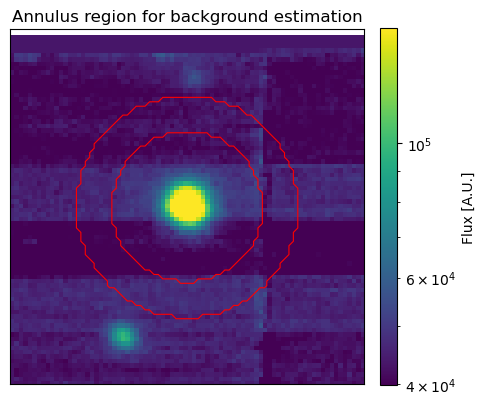

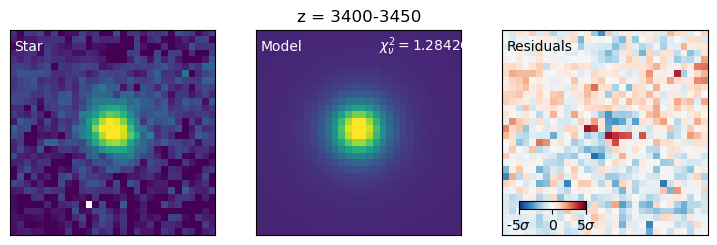

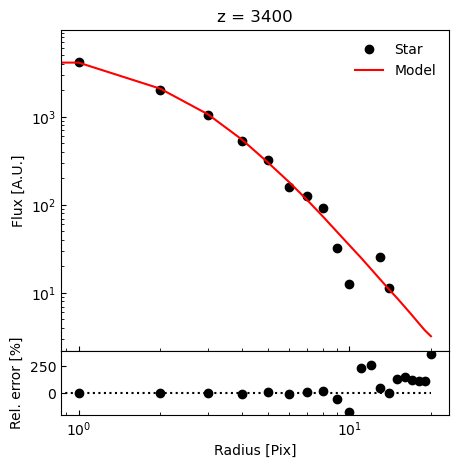

  x0 = 14.451
  y0 = 14.865
  amplitude = 1.047e+00
  FWHM = 3.446
  beta = 1.873
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [ 6.43921484e+03  4.24673291e+03  2.03794165e+03  1.05268750e+03
  5.34524109e+02  3.25640869e+02  1.60730316e+02  1.27206085e+02
  9.21238327e+01  3.25606422e+01  1.25132818e+01 -1.87049961e+01
 -1.17578249e+01  2.53519516e+01  1.15087957e+01 -3.04349556e+01
 -1.39212580e+01 -2.64853668e+01 -2.64952602e+01 -4.34526443e+01
 -1.19707298e+00]
 
  fit_prof = [6.6306538e+03 4.1358442e+03 2.0933430e+03 1.0706421e+03 5.5498065e+02
 3.0343970e+02 1.8046129e+02 1.1266260e+02 7.3207008e+01 4.9369827e+01
 3.4752209e+01 2.5337494e+01 1.8752262e+01 1.4192386e+01 1.0963362e+01
 8.7174988e+00 6.9490566e+00 5.6106501e+00 4.5476708e+00 3.7491813e+00
 3.2157874e+00]
     
     
[3600,3650]


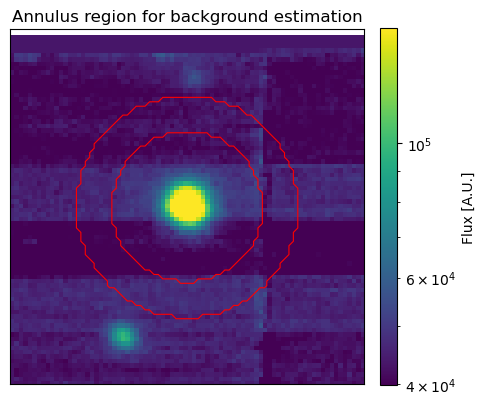

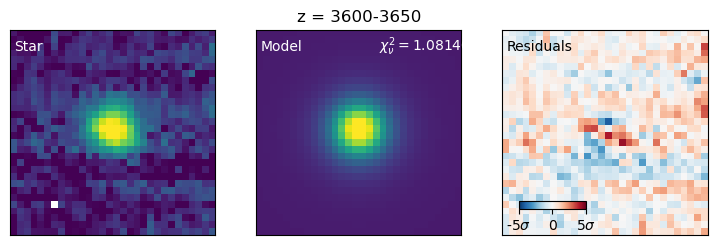

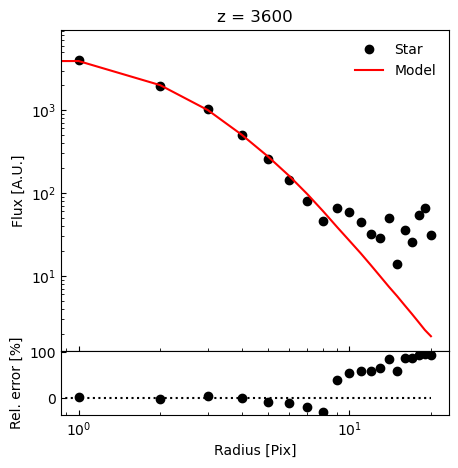

  x0 = 14.505
  y0 = 14.908
  amplitude = 1.037e+00
  FWHM = 3.679
  beta = 2.098
 
  r_prof = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
 
  img_prof = [6164.052    3991.5764   1974.673    1043.8126    500.99728   256.42685
  144.83981    81.09004    46.114975   65.332634   59.819187   45.07205
   32.06424    28.664295   49.778282   13.764522   35.607555   25.398932
   54.617027   65.66692    31.088642]
 
  fit_prof = [6.1072817e+03 3.8997703e+03 1.9988153e+03 9.9954962e+02 5.0493564e+02
 2.7603812e+02 1.6025896e+02 9.6587479e+01 6.0229828e+01 3.8946907e+01
 2.6609930e+01 1.8816811e+01 1.3497051e+01 9.8798361e+00 7.3903685e+00
 5.7153888e+00 4.4274955e+00 3.4967773e+00 2.7803123e+00 2.2300060e+00
 1.8766248e+00]
     
     
     
     
parlist:
[array([14.34371567, 15.09935321,  0.9989198 ,  5.27610993,  4.85868318]), array([14.40670019, 15.09649593,  1.02041272,  5.32789591,  5.35994148]), array([14.48528911, 15.07462148,  1.00659346,  5.37

In [18]:
# Fitting the star along the MUSE spectral range using normalized data

# Provide star's coordinates in the astropy's format
i = -1 # PSF MODEL SELECTION
star_coord = star_radec[i]
star_psf = FHMW_Beta_list[i]  
star_flux = flux_list[i]

star_FHWM, star_beta = star_psf[0], star_psf[1]

coord = SkyCoord(star_coord[0], star_coord[1], unit='deg', frame='icrs', equinox='J2000')
print(coord)

# Set cutout size in pixels
cutout_size = 30
x, y = np.meshgrid(np.arange(cutout_size), np.arange(cutout_size))

# Initial guess for Moffat parameters
x0_guess = cutout_size / 2
y0_guess = cutout_size / 2

# beta mas grande = alas más apretadas
#guess = [float(x0_guess), float(y0_guess), 1.2, 3.5, 3.5]
#lo_bounds = [x0_guess - 5, y0_guess - 5, 0, 1, 1]
#up_bounds = [x0_guess + 5, y0_guess + 5, 4, 5, 8]

#guess = [float(x0_guess), float(y0_guess), star_flux, star_FHWM, star_beta]
#guess = [12.19190346, 11.8708457,   1.09758863,  3.06052643,  2.56841205]

guess = [12.06447273, 11.84000283,  1.07655817,  3.26052643,  2.66879]

lo_bounds = [x0_guess - 5, y0_guess - 5, star_flux*0.8, star_FHWM*0.8, star_beta*0.8]
up_bounds = [x0_guess + 5, y0_guess + 5, star_flux*1.5, star_FHWM*1.5, star_beta*1.5]

for val, low, high in zip(guess, lo_bounds, up_bounds):
    print(f"param: {val}, bounds: [{low}, {high}], in bounds: {low <= val <= high}")

print("=================================================================================")

z_fitstep, z_plotstep = 50, 200
par_list = []
annulus_background = True

for k in np.arange(0, cube.shape[0], z_fitstep):


    img = np.nansum(cube[k:k+z_fitstep, :, :], axis=0)
    if np.all(np.isnan(img)):
        par_list.append([np.nan] * len(guess))
        continue

    # Cutout of image and error cube
    cutout = Cutout2D(img, coord, size=cutout_size, wcs=wcs_2d, mode='partial', fill_value=0)
    cutout_img = cutout.data
    del cutout


    #img_var = np.nansum(vcube[k:k+z_fitstep, :, :], axis=0)
    #img_err = np.sqrt(img_var)  # <- raíz de la varianza
    #cutout = Cutout2D(img_err, coord, size=cutout_size, wcs=wcs_2d, mode='partial', fill_value=0)
    #cutout_img_err = cutout.data


    img_var = np.nansum(vcube[k:k+z_fitstep, :, :], axis=0)
    cutout = Cutout2D(np.sqrt(img_var), coord, size=cutout_size, wcs=wcs_2d, mode='partial', fill_value=0)
    cutout_img_err = cutout.data
    del cutout

    # Mask invalid pixels
    mask = (cutout_img == 0) | np.isnan(cutout_img)
    x_aux = x[~mask]
    y_aux = y[~mask]
    cutout_img_aux = cutout_img[~mask]
    cutout_img_err_aux = cutout_img_err[~mask]

    if cutout_img_aux.size == 0 or cutout_img_err_aux.size == 0:
        with open("z_trace.txt", "a") as f:
            f.write(f"Empty data at index {k}-{k+z_fitstep}\n")
        par_list.append([np.nan] * len(guess))
        continue

    # Normalización segura
    norm = np.nanmax(cutout_img_aux)
    if not np.isfinite(norm) or norm == 0:
        with open("z_trace.txt", "a") as f:
            f.write(f"Invalid norm at index {k}-{k+z_fitstep}\n")
        par_list.append([np.nan] * len(guess))
        continue

    cutout_img_aux /= norm
    cutout_img_err_aux /= norm

    # Estadísticas de fondo y sustracción

    if annulus_background:

        szy_an, szx_an = img.shape
        x_an, y_an = np.meshgrid(np.arange(szx_an), np.arange(szy_an))

        xcen = matched_positions_nocont[i][0]
        ycen = matched_positions_nocont[i][1]

        radius = np.sqrt( (x_an - xcen)**2 + (y_an - ycen)**2 )
        annulus = (radius > 17) & (radius < 25)

        _, median, std = sigma_clipped_stats(img[annulus], sigma=3.0)


    else:
        _, median, std = sigma_clipped_stats(cutout_img, sigma=3.0)
        #std = np.nanstd(cutout_img_aux)

    
    cutout_img -= median


    test_model = moffat2D((x_aux, y_aux), *guess)

    # print("----------")
    # print("¿NaN en modelo inicial?:", np.any(np.isnan(test_model)))
    # print("¿Inf en modelo inicial?:", np.any(np.isinf(test_model)))
    # print("¿NaN en datos?:", np.any(np.isnan(cutout_img_aux)))
    # print("¿NaN en errores?:", np.any(np.isnan(cutout_img_err_aux)))
    # print("¿NaN en x/y?:", np.any(np.isnan(x_aux)), np.any(np.isnan(y_aux)))
    # print("----------")
 

    try:
        #mask_2 = ~np.isnan(cutout_img_err_aux.ravel())

        #print(f"Total de puntos válidos: {np.sum(mask_2)} de {mask_2.size}")

        popt_psf, pcov_psf = curve_fit(
            moffat2D,
            (x_aux.ravel(), y_aux.ravel()),
            cutout_img_aux.ravel(),
            p0=guess,
            sigma=cutout_img_err_aux.ravel(),
            #bounds=(lo_bounds, up_bounds)
            )

        par_list.append(popt_psf)
        #print(popt_psf)
    except RuntimeError:
        with open("z_trace.txt", "a") as f:
            f.write(f"Fit failed at index {k}\n")
        par_list.append([np.nan] * len(guess))
        continue

    if k % z_plotstep == 0:
        print(f"[{k},{k+z_fitstep}]")

        if annulus_background:
            #-------------- -------------- -------------- -------------- --------------#
            fig, ax = plt.subplots(figsize=(5,5))
            minval = np.nanmin(white_img)
            p = np.nanpercentile(white_img - minval, [16, 99.5])

            col_norm = colors.LogNorm(vmin=p[0], vmax=p[1])

            im = ax.imshow(white_img - minval, origin='lower', norm=col_norm, cmap='viridis')
            ax.contour(annulus, colors='r', linewidths=0.8)

            # barra de color
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label("Flux [A.U.]")

            ax.set_title("Annulus region for background estimation")
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlim(xcen-40,xcen+40)
            ax.set_ylim(ycen-40,ycen+40)

            plt.show()

            #-------------- -------------- -------------- -------------- --------------#


        fit_aux = moffat2D((x_aux, y_aux), *popt_psf)

        fit = cutout_img * 0
        fit[~mask] = fit_aux * norm  # des-normaliza el modelo
        resid = (cutout_img - fit) / std  # residuales en unidades de ruido

        do_imshow_plot(cutout_img, fit, resid, Npars=len(popt_psf),mask=~mask, title=f'z = {k}-{k+z_fitstep}') #mask no especificada


        radius = np.sqrt((x - popt_psf[0]) ** 2 + (y - popt_psf[1]) ** 2)
        r_prof, img_prof, fit_prof = radial_prof(cutout_img, radius, model=fit)

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(r_prof, img_prof, 'ok', label='Star')
        ax.plot(r_prof, fit_prof, '-r', label='Model')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.tick_params(axis="both", direction="in", which='both')
        ax.set_ylabel('Flux [A.U.]')
        ax.set_title(f'z = {k}')
        ax.legend(frameon=False)

        divider = make_axes_locatable(ax)
        ax2 = divider.append_axes("bottom", size="20%", pad=0)
        ax.figure.add_axes(ax2)
        ax2.plot(r_prof, 100 * (1 - fit_prof / img_prof), 'ok')
        ax2.plot(r_prof, img_prof * 0, ':k', linewidth=1.5)
        ax2.set_xscale('log')
        ax2.tick_params(axis="both", direction="in", which='both')
        ax2.set_ylabel('Rel. error [%]')
        ax2.set_xlabel('Radius [Pix]')
        plt.show()


        print(f"  x0 = {popt_psf[0]:.3f}")
        print(f"  y0 = {popt_psf[1]:.3f}")
        print(f"  amplitude = {popt_psf[2]:.3e}")
        print(f"  FWHM = {popt_psf[3]:.3f}")
        print(f"  beta = {popt_psf[4]:.3f}")
        print(" ")
        print("  r_prof =", r_prof)
        print(" ")
        print("  img_prof =", img_prof)
        print(" ")
        print("  fit_prof =", fit_prof)
        print("     ")
        print("     ")

print("     ")
print("     ")
print("parlist:")
print(par_list)


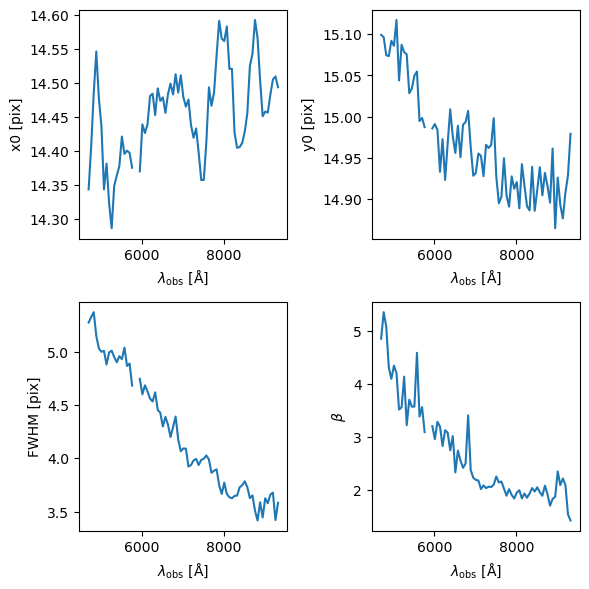

In [19]:
z_arr, par_arr = np.arange(0, np.shape(cube)[0], z_fitstep), np.array(par_list)


wl_obs = (z_arr - (header['CRPIX3']-1)) * header['CD3_3'] + header['CRVAL3']               
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
   
ax[0,0].plot(wl_obs, par_arr[:,0])
ax[0,0].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[0,0].set_ylabel('x0 [pix]')

ax[0,1].plot(wl_obs, par_arr[:,1])
ax[0,1].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[0,1].set_ylabel('y0 [pix]')


ax[1,0].plot(wl_obs, par_arr[:,3])
ax[1,0].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[1,0].set_ylabel('FWHM [pix]')
#ax[1,0].legend(frameon=False)

ax[1,1].plot(wl_obs, par_arr[:,4])
ax[1,1].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[1,1].set_ylabel(r'$\beta$')

fig.tight_layout()
plt.show()

### Fit FWHM and beta

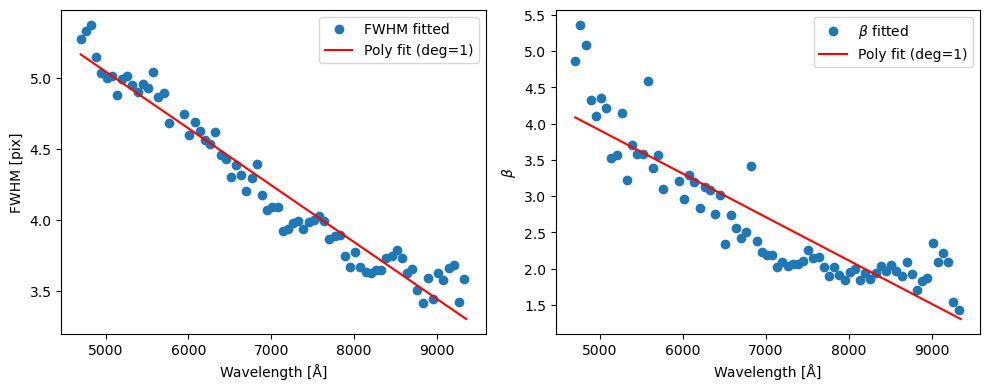

In [20]:
from numpy.polynomial.polynomial import Polynomial

# Arrays de entrada
z_arr = np.arange(0, cube.shape[0], z_fitstep)
par_arr = np.array(par_list)
fwhm_vals = par_arr[:, 3]
beta_vals = par_arr[:, 4]

# Ejes de longitud de onda
wl_obs_sub = (z_arr - (header['CRPIX3'] - 1)) * header['CD3_3'] + header['CRVAL3']
full_wl_obs = (np.arange(header['NAXIS3']) - (header['CRPIX3'] - 1)) * header['CD3_3'] + header['CRVAL3']

# -----------------------
# Ajuste polinomial seguro
# -----------------------

deg = 1  # Cambia a 1, 2, etc. si prefieres un grado distinto

# Máscara para datos finitos (válidos)
valid_mask = (
    np.isfinite(wl_obs_sub) &
    np.isfinite(fwhm_vals) &
    np.isfinite(beta_vals) &
    (fwhm_vals > 0)
)

# Aplicar máscara a los datos
wl_fit = wl_obs_sub[valid_mask]
fwhm_fit = fwhm_vals[valid_mask]
beta_fit = beta_vals[valid_mask]

# Verifica si hay suficientes puntos para ajustar
if len(wl_fit) <= deg:
    raise ValueError(f"No hay suficientes puntos válidos ({len(wl_fit)}) para ajuste de grado {deg}")

# Ajustar polinomios
coeffs_fwhm = np.polyfit(wl_fit, fwhm_fit, deg)
coeffs_beta = np.polyfit(wl_fit, beta_fit, deg)

# Evaluar en el eje completo
f_fitted = np.polyval(coeffs_fwhm, full_wl_obs)
b_fitted = np.polyval(coeffs_beta, full_wl_obs)

# -----------------------
# Graficar
# -----------------------
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(wl_fit, fwhm_fit, 'o', label='FWHM fitted')
ax[0].plot(full_wl_obs, f_fitted, '-', label=f'Poly fit (deg={deg})', c = "red")
ax[0].set_ylabel('FWHM [pix]')
ax[0].set_xlabel('Wavelength [Å]')
ax[0].legend()

ax[1].plot(wl_fit, beta_fit, 'o', label=r'$\beta$ fitted')
ax[1].plot(full_wl_obs, b_fitted, '-', label=f'Poly fit (deg={deg})',c="red")
ax[1].set_ylabel(r'$\beta$')
ax[1].set_xlabel('Wavelength [Å]')
ax[1].legend()

plt.tight_layout()
plt.show()



### Go trought wavelenght (QSO) using star psf